In [ ]:
#! pip3 install -r ../requirements.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
from sklearn.preprocessing import StandardScaler
import warnings
from scipy import stats
warnings.filterwarnings("ignore")
#pd.set_option('display.max_rows', None)

## Data preparation

root_directory = "your root directory here"
data_directory = "your data directory here"

def ROOT_DIRECTORY():

    global root_directory
    if root_directory == "your root directory here":
        
        root_directory = "."
    return root_directory

def DATA_DIRECTORY():
    
    global data_directory
    if data_directory == "your data directory here":
        
        data_directory = "data/csv_ergast_data"
    
    return data_directory
### Loading data
# LOADING ERGAST DATA
def unzip_data(file_name='f1db_csv.zip', root_directory=ROOT_DIRECTORY(), data_directory=DATA_DIRECTORY()):
    
    path = os.path.join(ROOT_DIRECTORY(), DATA_DIRECTORY(),'f1db_csv.zip')
    with zipfile.ZipFile(path, 'r') as myzip:
        myzip.extractall(os.path.join(ROOT_DIRECTORY(), DATA_DIRECTORY()))

def get_data_from_csv(file_name, root_directory=ROOT_DIRECTORY(), data_directory=DATA_DIRECTORY()):            
    
    csv_data_directory = os.path.join(root_directory, data_directory, file_name)
    return pd.read_csv(csv_data_directory)

file_names = {"drivers": "drivers.csv", "driver_standings":"driver_standings.csv",
                "circuits": "circuits.csv", 'races': 'races.csv',
                'constructor_results': 'constructor_results.csv', 
                'constructor_standings': 'constructor_standings.csv',
                'constructors': 'constructors.csv', "lap_times": "lap_times.csv", 'pit_stops': 'pit_stops.csv',
                "qualifying": "qualifying.csv", 'results': 'results.csv',
                'seasons': 'seasons.csv', 'status':'status.csv'}

## Preliminary data treatment and evaluation
circuits = get_data_from_csv(file_names['circuits'])
constructors = get_data_from_csv(file_names["constructors"])
pit_stops = get_data_from_csv(file_names["pit_stops"])
qualifying = get_data_from_csv(file_names["qualifying"])

races = get_data_from_csv(file_names['races'])

drivers = get_data_from_csv("drivers.csv")
lap_times = get_data_from_csv(file_names['lap_times'])

In [ ]:
#max rowns for comfortable exploration
pd.options.display.max_rows = 999

In [ ]:
drivers = drivers[["driverId", "forename", "surname"]].set_index("driverId")
drivers.head()

,forename,surname
driverId,,
1,Lewis,Hamilton
2,Nick,Heidfeld
3,Nico,Rosberg
4,Fernando,Alonso
5,Heikki,Kovalainen


## Races data merging

### pit-stops data exploration and treatment

In [ ]:
pit_stops =  get_data_from_csv(file_names["pit_stops"])
pit_stops.rename(columns={"milliseconds":'pit_stops_ms', "stop":"pit_stop_number", "lap": "ps_lap"}, inplace=True)
pit_stops.drop(columns=['time', "duration"], axis=1, inplace=True)
results = pd.read_csv("./data/csv_ergast_data/results.csv")
pit_stops = pd.merge(pit_stops, results, how="left", on= ["raceId", "driverId"])[list(pit_stops.columns) + ["constructorId"]] #joining every pitstop record with it constructorId key
races =  get_data_from_csv(file_names["races"])
pit_stops = pd.merge(pit_stops, races, how="left", on=["raceId"])[list(pit_stops.columns) + ["circuitId", "year","round"]] #joining every pitstop record with it circuitId key
pit_stops = pd.merge(pit_stops, circuits, how="left", on="circuitId")[list(pit_stops.columns) + ["circuitRef"]] #joining every pitstop record with it circuitRef key by the use of the circuit primary key
pit_stops = pd.merge(pit_stops, constructors, how="left", on="constructorId")[list(pit_stops.columns) + ["constructorRef"]] #joining every pitstop record with it constructorRef key by the use of the constructor primary key

In [ ]:
pit_stops.circuitRef.nunique()

34

In [ ]:
pit_stops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9634 entries, 0 to 9633
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   raceId           9634 non-null   int64 
 1   driverId         9634 non-null   int64 
 2   pit_stop_number  9634 non-null   int64 
 3   ps_lap           9634 non-null   int64 
 4   pit_stops_ms     9634 non-null   int64 
 5   constructorId    9634 non-null   int64 
 6   circuitId        9634 non-null   int64 
 7   year             9634 non-null   int64 
 8   round            9634 non-null   int64 
 9   circuitRef       9634 non-null   object
 10  constructorRef   9634 non-null   object
dtypes: int64(9), object(2)
memory usage: 903.2+ KB


In [ ]:
pit_stops.groupby("circuitRef").raceId.nunique()

circuitRef
albert_park       10
americas          10
bahrain           12
baku               6
buddh              3
catalunya         12
hockenheimring     5
hungaroring       12
imola              3
interlagos        11
istanbul           3
jeddah             2
losail             1
marina_bay        10
miami              1
monaco            11
monza             12
mugello            1
nurburgring        3
portimao           2
red_bull_ring     11
ricard             4
rodriguez          7
sepang             7
shanghai           9
silverstone       13
sochi              8
spa               11
suzuka            10
valencia           2
villeneuve        10
yas_marina        12
yeongam            3
zandvoort          2
Name: raceId, dtype: int64

In [ ]:
#deleting outliers, those data abode upper limit
Q1, Q3 = np.quantile(pit_stops['pit_stops_ms'], 0.25), np.quantile(pit_stops['pit_stops_ms'], 0.75)
IQR = Q3-Q1
low_lim = Q1 - 1.5 * IQR
up_lim = Q3 + 1.5 * IQR
pit_stops_without_outliers = pit_stops[pit_stops["pit_stops_ms"] <= up_lim ] #withouth outliers

In [ ]:
pit_stops_without_outliers.head()

,raceId,driverId,pit_stop_number,ps_lap,pit_stops_ms,constructorId,circuitId,year,round,circuitRef,constructorRef
0,841,153,1,1,26898,5,1,2011,1,albert_park,toro_rosso
1,841,30,1,1,25021,131,1,2011,1,albert_park,mercedes
2,841,17,1,11,23426,9,1,2011,1,albert_park,red_bull
3,841,4,1,12,23251,6,1,2011,1,albert_park,ferrari
4,841,13,1,13,23842,6,1,2011,1,albert_park,ferrari


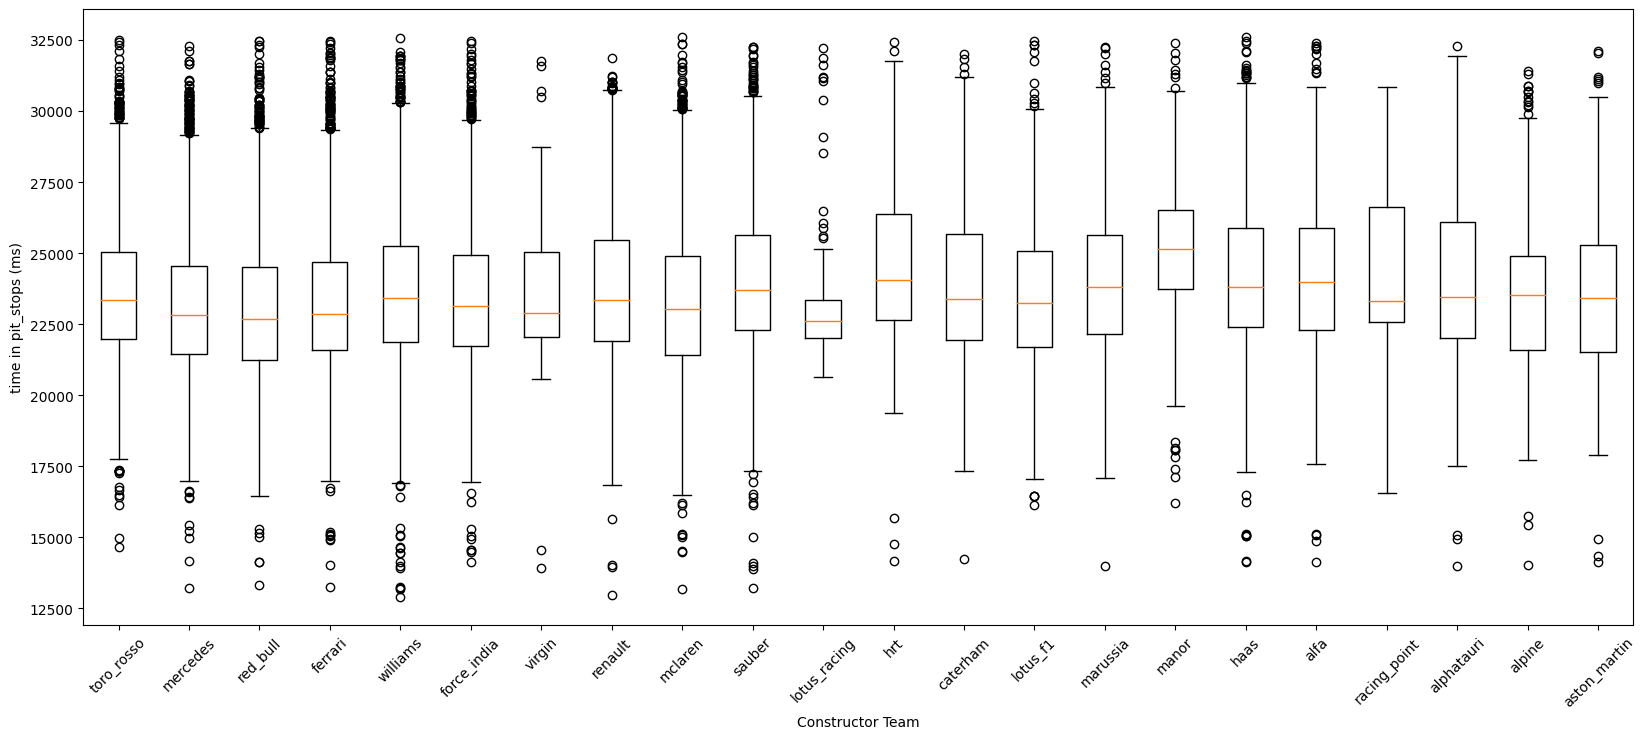

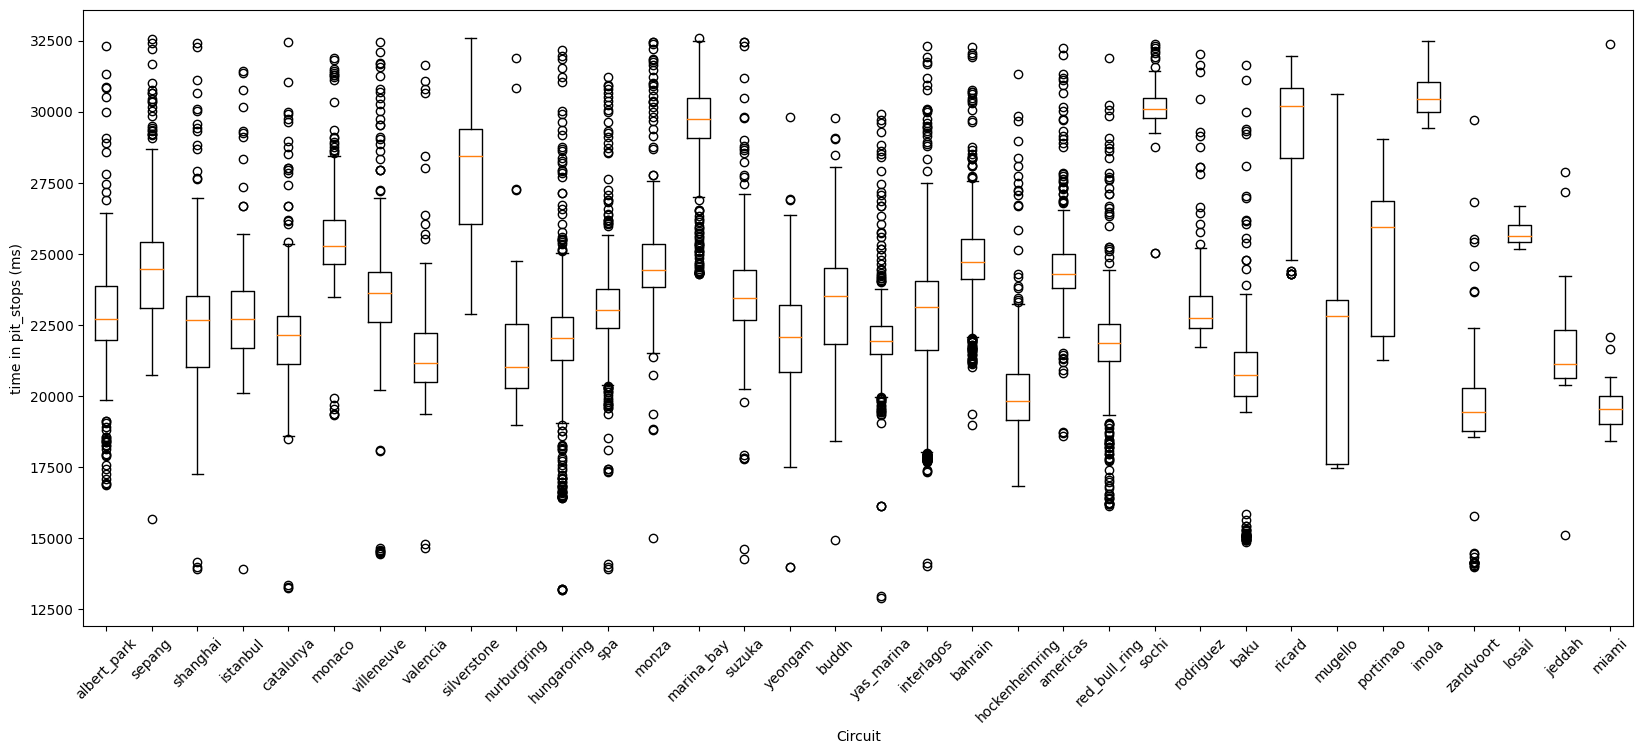

In [ ]:
df = pit_stops_without_outliers.copy()

 # building columns for pits_tops time per constructor
column_constructors = []
for id in df.constructorRef.unique():
    df.loc[df["constructorRef"]==id, id] = df.loc[df["constructorRef"]==id,'pit_stops_ms']

    column_constructors.append(id)

 # building columns for pits_tops time per circuit
column_circuits = []
for id in df.circuitRef.unique():
    df.loc[df["circuitRef"]==id, id] = df.loc[df["circuitRef"]==id,'pit_stops_ms']

    column_circuits.append(id)

fig, ax = plt.subplots(figsize=(20, 8))
boxplot = ax.boxplot([df[~df[column].isna()][f'{column}'].values for column in column_constructors], vert=True, labels = column_constructors)
plt.xticks(rotation=45)
ax.set_ylabel('time in pit_stops (ms)')
ax.set_xlabel('Constructor Team')
plt.show()

fig, ax = plt.subplots(figsize=(20, 8))
boxplot = ax.boxplot([df[~df[column].isna()][f'{column}'].values for column in column_circuits], vert=True, labels = column_circuits)
plt.xticks(rotation=45)
ax.set_ylabel('time in pit_stops (ms)')
ax.set_xlabel('Circuit')
plt.show()

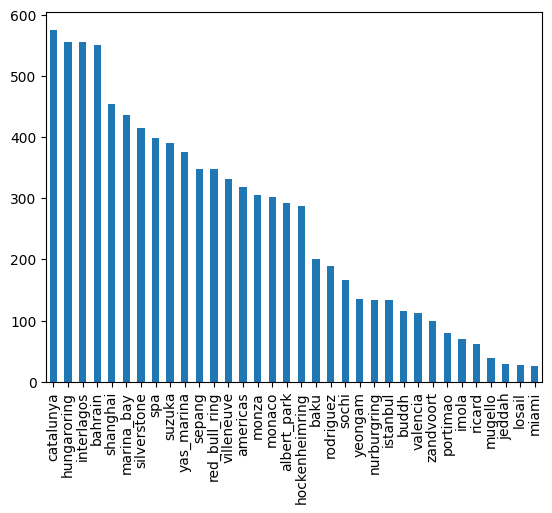

In [ ]:
df["circuitRef"].value_counts().plot(kind="bar");
plt.show()

In [ ]:
avg_per_constructor = df.groupby(["constructorRef"]).pit_stops_ms.mean()
avg_per_circuit = df.groupby("circuitRef").pit_stops_ms.mean()

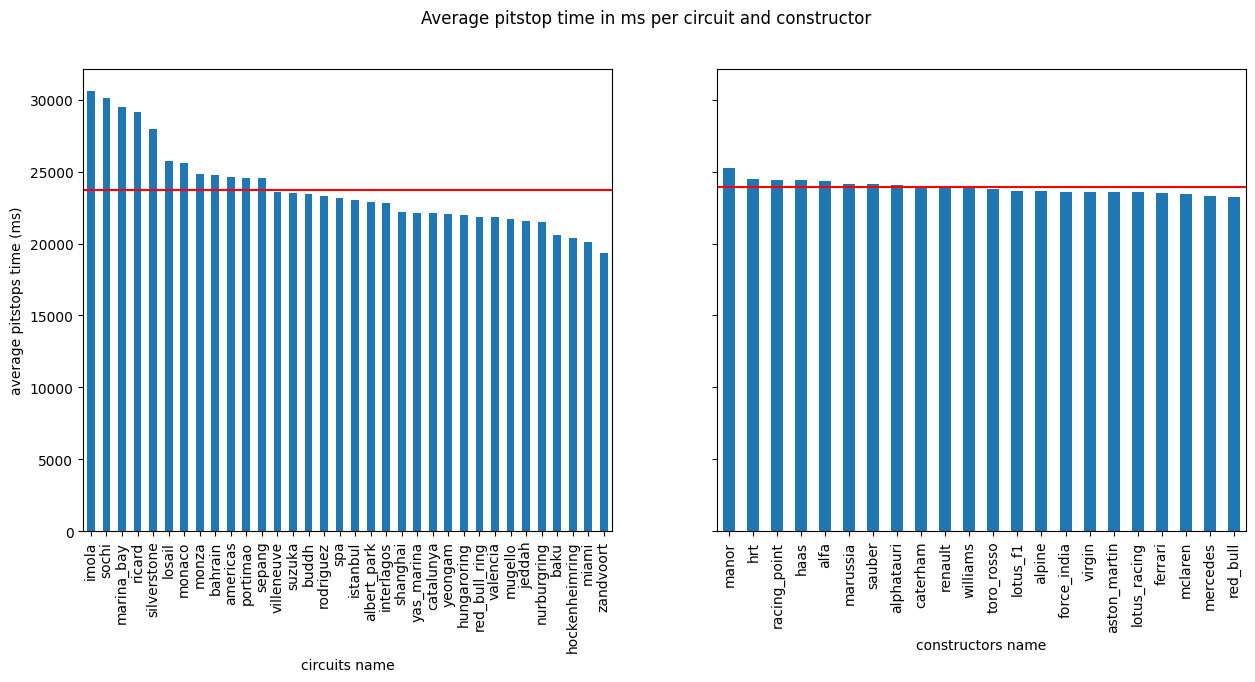

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15,6))
fig.suptitle('Average pitstop time in ms per circuit and constructor')
avg_per_circuit.sort_values(ascending=False).plot(kind="bar", ax=ax1, ylabel="average pitstops time (ms)", xlabel="circuits name");
ax1.axhline(avg_per_circuit.mean(), color = 'red')
plt.xticks(rotation=75)
# for tick in ax1.get_xticklabels():
#     tick.set_rotation(75)

avg_per_constructor.sort_values(ascending=False).plot(kind="bar", ax=ax2, ylabel="average pitstops time (ms)", xlabel="constructors name");
ax2.axhline(avg_per_constructor.mean(), color = 'red')

plt.show();

In [ ]:
stats.kruskal(avg_per_constructor, avg_per_circuit, nan_policy='omit', axis=0, keepdims=False)

KruskalResult(statistic=2.8710948494230024, pvalue=0.09018350061245323)

Pitstops time seems to be highly dependent on the circuit where the race is happening and varies upon constructors. On the other hand, considering how these values will be provided in reality, for a prediction in a production environment,
I could say that:
pitstops averages will be provided for the constructor, instead of actual values at the races (the race is an event it does not happen yet). Then, model would be trained with the same type of data: average times per constructor computed from the historical data instead of the actual values per race.

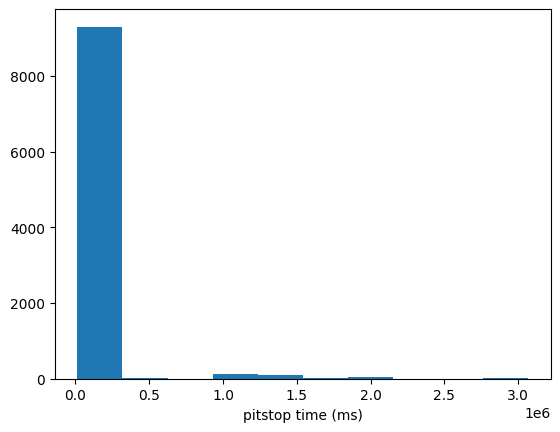

In [ ]:
plt.hist(pit_stops['pit_stops_ms']);
plt.xlabel("pitstop time (ms)");

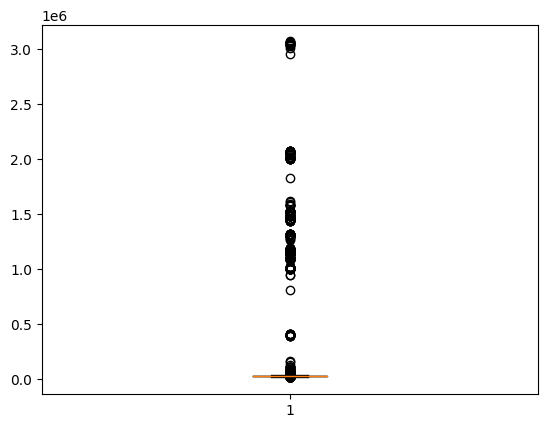

In [ ]:
plt.boxplot(pit_stops['pit_stops_ms']);#outlied data

As I have to obtain an aggregation parameter for the pitstops timing during a race for a driver, I need to keep representative data. There is some races that kepts dead time on races that were for other reasons besides the pitstops, for examples because accidents or safety cars. I will keep all data, but the outliers from above will be replaced by the pitstops time avg per constructor.

In [ ]:
pit_stops

,raceId,driverId,pit_stop_number,ps_lap,pit_stops_ms,constructorId,circuitId,year,round,circuitRef,constructorRef
0,841,153,1,1,26898,5,1,2011,1,albert_park,toro_rosso
1,841,30,1,1,25021,131,1,2011,1,albert_park,mercedes
2,841,17,1,11,23426,9,1,2011,1,albert_park,red_bull
3,841,4,1,12,23251,6,1,2011,1,albert_park,ferrari
4,841,13,1,13,23842,6,1,2011,1,albert_park,ferrari
...,...,...,...,...,...,...,...,...,...,...,...
9629,1096,849,2,38,25174,3,24,2022,22,yas_marina,williams
9630,1096,840,2,40,21802,117,24,2022,22,yas_marina,aston_martin
9631,1096,839,2,41,21734,214,24,2022,22,yas_marina,alpine
9632,1096,846,2,42,21559,1,24,2022,22,yas_marina,mclaren


In [ ]:
pit_stops.shape

(9634, 11)

In [ ]:
pit_stops =  get_data_from_csv(file_names["pit_stops"])
pit_stops.rename(columns={"milliseconds":'pit_stops_ms', "stop":"pit_stop_number", "lap": "ps_lap"}, inplace=True)
pit_stops.drop(columns=['time', "duration"], axis=1, inplace=True)
results = pd.read_csv("./data/csv_ergast_data/results.csv")
pit_stops = pd.merge(pit_stops, results, how="left", on= ["raceId", "driverId"])[list(pit_stops.columns) + ["constructorId"]] #joining every pitstop record with it constructorId key
races =  get_data_from_csv(file_names["races"])
pit_stops = pd.merge(pit_stops, races, how="left", on=["raceId"])[list(pit_stops.columns) + ["circuitId", "year","round"]] #joining every pitstop record with it circuitId key
pit_stops = pd.merge(pit_stops, circuits, how="left", on="circuitId")[list(pit_stops.columns) + ["circuitRef"]] #joining every pitstop record with it circuitRef key by the use of the circuit primary key
pit_stops = pd.merge(pit_stops, constructors, how="left", on="constructorId")[list(pit_stops.columns) + ["constructorRef"]] #joining every pitstop record with it constructorRef key by the use of the constructor primary key

In [ ]:
pit_stops.circuitRef.nunique()

34

In [ ]:
pit_stops.shape

(9634, 11)

In [ ]:
# for a race and a driver, the avg pitstop time as aggregation parameter for the hole dataset
for race in pit_stops.raceId.unique():
    
    for driver in pit_stops.loc[pit_stops["raceId"] == race,'driverId'].unique():
        mask = (pit_stops["raceId"] == race) & (pit_stops["driverId"] == driver)
        data = pit_stops[mask]
        pit_stops.loc[mask,"ps_avg_ms"] = data['pit_stops_ms'].mean()


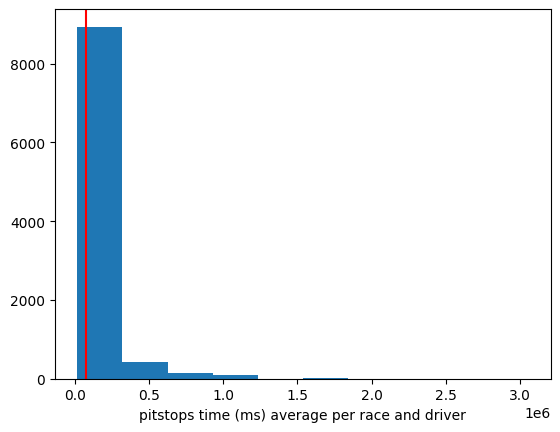

In [ ]:
plt.hist(pit_stops["ps_avg_ms"]);
plt.axvline(pit_stops["ps_avg_ms"].mean(), color="red")
plt.xlabel("pitstops time (ms) average per race and driver")
plt.show();

In [ ]:
pit_stops = pd.merge(pit_stops, pd.DataFrame(pit_stops.groupby(["raceId","driverId"]).max()["pit_stop_number"].reset_index()).rename(columns={'pit_stop_number':'total_pit_stops'}), on=['raceId','driverId'])
Q1, Q3 = np.quantile(pit_stops['pit_stops_ms'], 0.25), np.quantile(pit_stops['pit_stops_ms'], 0.75)
IQR = Q3-Q1
low_lim = Q1 - 1.5 * IQR
up_lim = Q3 + 1.5 * IQR
pit_stops_without_outliers = pit_stops[pit_stops["pit_stops_ms"] <= up_lim ] # excluding races with pitstops above up_limit
ps_to_replace = pit_stops[pit_stops["pit_stops_ms"] > up_lim] # dataset with outliers
print(pit_stops.shape)

(9634, 13)


In [ ]:
pit_stops_without_outliers.head()


,raceId,driverId,pit_stop_number,ps_lap,pit_stops_ms,constructorId,circuitId,year,round,circuitRef,constructorRef,ps_avg_ms,total_pit_stops
0,841,153,1,1,26898,5,1,2011,1,albert_park,toro_rosso,25903.0,3
1,841,153,2,17,24463,5,1,2011,1,albert_park,toro_rosso,25903.0,3
2,841,153,3,35,26348,5,1,2011,1,albert_park,toro_rosso,25903.0,3
3,841,30,1,1,25021,131,1,2011,1,albert_park,mercedes,24504.5,2
4,841,30,2,17,23988,131,1,2011,1,albert_park,mercedes,24504.5,2


In [ ]:
# for a race and a driver, I will keep the avg pitstop time as aggregation parameter
for race in pit_stops_without_outliers.raceId.unique():
    
    for driver in pit_stops_without_outliers.loc[pit_stops_without_outliers["raceId"] == race,'driverId'].unique():
        mask = (pit_stops_without_outliers["raceId"] == race) & (pit_stops_without_outliers["driverId"] == driver)
        data = pit_stops_without_outliers[mask]
        pit_stops_without_outliers.loc[mask,"ps_avg_ms"] = data['pit_stops_ms'].mean()

pit_stops_without_outliers = pit_stops_without_outliers.sort_values(by=['year', "round","constructorRef"]).set_index(['year', "round"])

In [ ]:
for i,row in ps_to_replace.iterrows():
    
    year = row["year"]
    round = row["round"]
    constructor = row["constructorId"]

    new_values_this_round = pit_stops_without_outliers[(pit_stops_without_outliers.index == (year,round)) & (pit_stops_without_outliers["constructorId"] == constructor)]["ps_avg_ms"].values

    previous_year = year
    previous_round = round-1
    if round == 1:# previous race will be of the previous year
        previous_year = year - 1
        previous_round = pit_stops_without_outliers[pit_stops_without_outliers.index.get_level_values("year").isin([previous_year])].index.get_level_values("round").max()

    new_values_previous_round =pit_stops_without_outliers[(pit_stops_without_outliers.index == (previous_year, previous_round)) & (pit_stops_without_outliers["constructorId"] == constructor)]["ps_avg_ms"].values
    
    ps_to_replace.loc[i,'ps_avg_ms'] = new_values_this_round[-1] if len(new_values_this_round) > 0 else (new_values_previous_round[-1] if len(new_values_previous_round)>0 else np.nan)

ps_to_replace = ps_to_replace.drop(["pit_stop_number",'ps_lap','pit_stops_ms'], axis=1)

In [ ]:
print(ps_to_replace.shape)
ps_to_replace = ps_to_replace.dropna()
ps_to_replace.shape

(773, 10)


(772, 10)

In [ ]:
pit_stops_without_outliers = pit_stops_without_outliers.reset_index()
print(pit_stops_without_outliers.shape)
pit_stops_without_outliers = pit_stops_without_outliers.drop(["ps_lap", "pit_stops_ms", 'pit_stop_number'], axis=1) # deleting columns that distinct data among laps, we want one row per race
pit_stops_without_outliers=pit_stops_without_outliers.drop_duplicates()
print(pit_stops_without_outliers.shape)

(8861, 13)
(4586, 10)


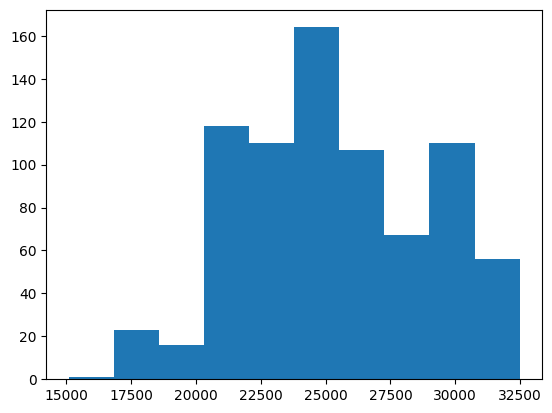

In [ ]:
plt.hist(ps_to_replace["ps_avg_ms"]); #outlied data with pitstops time replaced by avg per constructor

In [ ]:
ps_to_replace.set_index(["year", "round"], inplace=True)
ps_to_replace.head()

raceId  driverId  constructorId  circuitId   circuitRef  \
year round                                                            
2011 1         841        22              3          1  albert_park   
     2         842        22              3          2       sepang   
     2         842        24            164          2       sepang   
     3         843        10            166         17     shanghai   
     4         844         1              1          5     istanbul   

           constructorRef     ps_avg_ms  total_pit_stops  
year round                                                
2011 1           williams  22281.333333                4  
     2           williams  24502.000000                2  
     2                hrt  27184.500000                3  
     3             virgin  22851.500000                3  
     4            mclaren  21808.000000                4

In [ ]:
pit_stops_without_outliers.set_index(["year", "round"], inplace=True)
pit_stops_without_outliers.head()

raceId  driverId  constructorId  circuitId   circuitRef  \
year round                                                            
2011 1         841         4              6          1  albert_park   
     1         841        13              6          1  albert_park   
     1         841       814             10          1  albert_park   
     1         841        16             10          1  albert_park   
     1         841        15            205          1  albert_park   

           constructorRef     ps_avg_ms  total_pit_stops  
year round                                                
2011 1            ferrari  24055.000000                3  
     1            ferrari  24145.666667                3  
     1        force_india  24597.500000                2  
     1        force_india  24924.500000                2  
     1       lotus_racing  24873.500000                2

In [ ]:
pit_stops= pd.concat([pit_stops_without_outliers,ps_to_replace]) #merging to get the final pitstop dataset


In [ ]:
pit_stops.circuitRef.nunique()

34

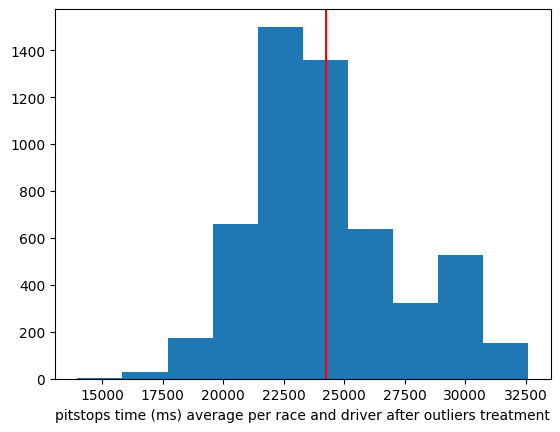

In [ ]:
plt.hist(pit_stops["ps_avg_ms"]);
plt.axvline(pit_stops["ps_avg_ms"].mean(), color="red")
plt.xlabel("pitstops time (ms) average per race and driver after outliers treatment");

compute the rolling avg per constuctor, of the last 10 values previous to the race:

In [ ]:
pit_stops = pit_stops.sort_values(by=["year","round"])
pit_stops["avg_per_constructor"] = pit_stops.groupby("constructorRef", as_index=False)[['ps_avg_ms']].transform(lambda x: x.rolling(10,1).mean())

In [ ]:
pit_stops.head()

raceId  driverId  constructorId  circuitId   circuitRef  \
year round                                                            
2011 1         841         4              6          1  albert_park   
     1         841        13              6          1  albert_park   
     1         841       814             10          1  albert_park   
     1         841        16             10          1  albert_park   
     1         841        15            205          1  albert_park   

           constructorRef     ps_avg_ms  total_pit_stops  avg_per_constructor  
year round                                                                     
2011 1            ferrari  24055.000000                3         24055.000000  
     1            ferrari  24145.666667                3         24100.333333  
     1        force_india  24597.500000                2         24597.500000  
     1        force_india  24924.500000                2         24761.000000  
     1       lotus_racing  24873.500000                2         24873.500000

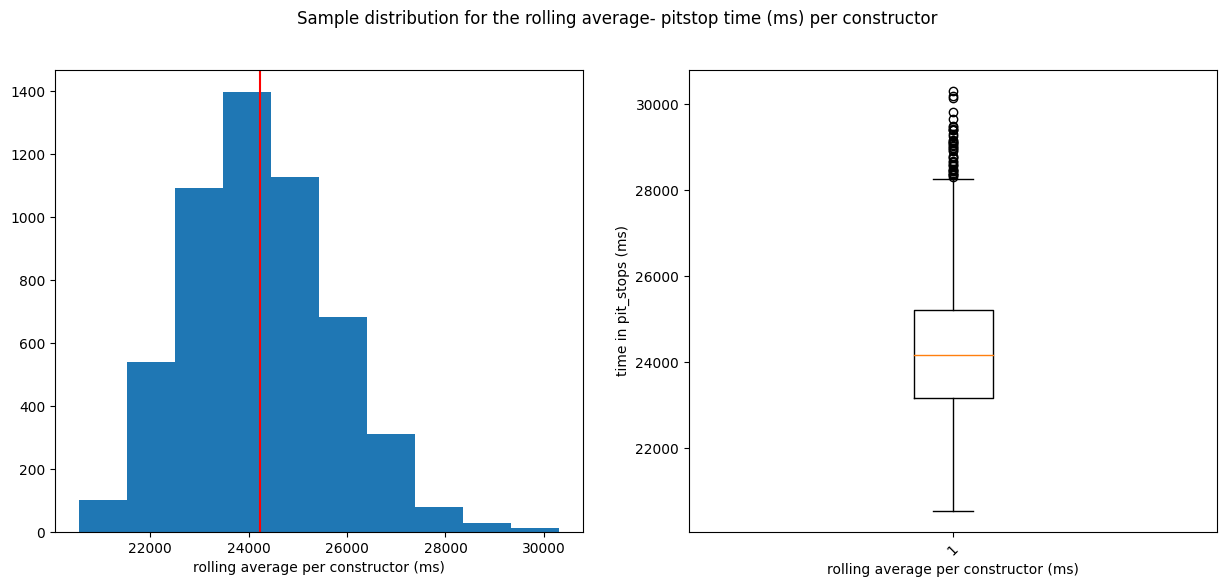

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(15,6))
fig.suptitle('Sample distribution for the rolling average- pitstop time (ms) per constructor')
ax1.hist(pit_stops["avg_per_constructor"]);
ax1.axvline(pit_stops["avg_per_constructor"].mean(), color = 'red')
ax1.set_xlabel('rolling average per constructor (ms)')
# avg_per_circuit.sort_values(ascending=False).plot(kind="bar", ax=ax1, ylabel="average pitstops time (ms)", xlabel="circuits name");

ax2.boxplot(pit_stops["avg_per_constructor"])
plt.xticks(rotation=45)
ax2.set_ylabel('time in pit_stops (ms)')
ax2.set_xlabel('rolling average per constructor (ms)')
# avg_per_constructor.sort_values(ascending=False).plot(kind="bar", ax=ax2, ylabel="average pitstops time (ms)", xlabel="constructors name");
# ax2.axhline(avg_per_constructor.mean(), color = 'red')

plt.show();

In [ ]:
len(pit_stops['avg_per_constructor'].values)

5358

In [ ]:
pit_stops.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5358 entries, (2011, 1) to (2022, 22)
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   raceId               5358 non-null   int64  
 1   driverId             5358 non-null   int64  
 2   constructorId        5358 non-null   int64  
 3   circuitId            5358 non-null   int64  
 4   circuitRef           5358 non-null   object 
 5   constructorRef       5358 non-null   object 
 6   ps_avg_ms            5358 non-null   float64
 7   total_pit_stops      5358 non-null   int64  
 8   avg_per_constructor  5358 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 388.4+ KB


In [ ]:
pd.options.display.max_rows = 9000

In [ ]:
pit_stops.circuitRef.nunique()

34

numer of races per year

In [ ]:
pit_stops.reset_index().groupby("year")["raceId"].nunique()

year
2011    19
2012    20
2013    19
2014    19
2015    19
2016    21
2017    20
2018    21
2019    21
2020    17
2021    21
2022    22
Name: raceId, dtype: int64

### Tyre strategy

#### Tire types as numerical value combined with stint

In [ ]:
tyres_num = get_data_from_csv("tyre_strategy_normalized_and_numeric_plus_2022.csv","./", "data/outputs/")
tyres_num = tyres_num[['stint_1_hard', 'year',
       'driverId', 'raceId', 'round', 'circuitId', 'stint_2_medium',
       'stint_3_hard', 'stint_1_medium', 'stint_2_hard', 'stint_4_soft',
       'stint_3_medium', 'stint_4_medium', 'stint_1_soft', 'stint_3_soft',
       'stint_2_soft', 'stint_4_hard', 'stint_5_soft', 'stint_5_medium',
       'stint_5_hard', 'stint_6_hard', 'stint_2_intermediate',
       'stint_3_intermediate', 'stint_4_intermediate', 'stint_5_intermediate',
       'stint_6_wet', 'stint_1_wet', 'stint_2_wet', 'stint_3_wet',
       'stint_4_wet', 'stint_5_wet', 'stint_1_intermediate', 'stint_6_soft',
       'stint_7_soft', 'stint_6_medium']]
tyres_num = tyres_num.fillna(0)

In [ ]:
pit_stops.head()

raceId  driverId  constructorId  circuitId   circuitRef  \
year round                                                            
2011 1         841         4              6          1  albert_park   
     1         841        13              6          1  albert_park   
     1         841       814             10          1  albert_park   
     1         841        16             10          1  albert_park   
     1         841        15            205          1  albert_park   

           constructorRef     ps_avg_ms  total_pit_stops  avg_per_constructor  
year round                                                                     
2011 1            ferrari  24055.000000                3         24055.000000  
     1            ferrari  24145.666667                3         24100.333333  
     1        force_india  24597.500000                2         24597.500000  
     1        force_india  24924.500000                2         24761.000000  
     1       lotus_racing  24873.500000                2         24873.500000

In [ ]:
#merging pitstops df and tyre_numerical
df_ml = pd.merge(pit_stops.reset_index(), tyres_num, on=["raceId","driverId"],how="inner")
df_ml = df_ml[['raceId', 'driverId', 'ps_avg_ms', 'total_pit_stops', 'year_y', 'round_y', 'circuitId_x','constructorId',
        'stint_1_hard','stint_2_medium', 'stint_3_hard', 'stint_1_medium', 'stint_2_hard', "constructorRef", "circuitRef",
       'stint_4_soft', 'stint_3_medium', 'stint_4_medium', 'stint_1_soft',
       'stint_3_soft', 'stint_2_soft', 'stint_4_hard', 'stint_5_soft',
       'stint_5_medium', 'stint_5_hard', 'stint_6_hard',
       'stint_2_intermediate', 'stint_3_intermediate', 'stint_4_intermediate',
       'stint_5_intermediate', 'stint_6_wet', 'stint_1_wet', 'stint_2_wet',
       'stint_3_wet', 'stint_4_wet', 'stint_5_wet', 'stint_1_intermediate',
       'stint_6_soft', 'stint_7_soft', 'stint_6_medium']]
df_ml.rename(columns = {'round_y': "round",'year_y':"year",'circuitId_x':"circuitId"}, inplace=True)
df_ml.T

,0,1,2,3,4,5,6,7,8,9,10,11,...,4172,4173,4174,4175,4176,4177,4178,4179,4180,4181,4182,4183
raceId,863,863,863,863,863,863,863,863,863,863,863,863,...,1096,1096,1096,1096,1096,1096,1096,1096,1096,1096,1096,1096
driverId,5,808,13,4,807,814,37,39,154,8,10,819,...,832,844,854,825,846,817,847,1,815,830,848,849
ps_avg_ms,23795.5,23333.0,22486.0,22916.666667,22473.0,22276.0,24060.333333,25458.5,22968.333333,22457.0,25334.666667,24020.0,...,21752.5,22210.0,22903.0,22387.0,21896.5,21893.0,26087.0,21270.0,21363.5,22735.0,21795.5,23798.5
total_pit_stops,4,3,3,3,3,2,3,4,3,3,3,1,...,2,1,2,1,2,1,2,1,2,1,2,2
year,2012,2012,2012,2012,2012,2012,2012,2012,2012,2012,2012,2012,...,2022,2022,2022,2022,2022,2022,2022,2022,2022,2022,2022,2022
round,4,4,4,4,4,4,4,4,4,4,4,4,...,22,22,22,22,22,22,22,22,22,22,22,22
circuitId,3,3,3,3,3,3,3,3,3,3,3,3,...,24,24,24,24,24,24,24,24,24,24,24,24
constructorId,207,207,6,6,10,10,164,164,208,208,206,206,...,6,6,210,210,1,1,131,131,9,9,3,3
stint_1_hard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
stint_2_medium,0.0,0.0,14.0,14.0,0.0,19.0,13.0,11.0,15.0,0.0,13.0,0.0,...,42.0,43.0,46.0,0.0,0.0,0.0,0.0,0.0,48.0,46.0,0.0,0.0


In [ ]:
df_ml.circuitRef.nunique()

33

### Load results for race (grid, position, total laps)

In [ ]:
results= get_data_from_csv("results.csv", root_directory="./", data_directory='data/csv_ergast_data')
results = results[["raceId", "driverId","grid", "position", "laps"]]
df_ml = pd.merge(df_ml, results, on=["raceId", "driverId"], how="left")

In [ ]:
df_ml.circuitRef.nunique()

33

In [ ]:
df_ml.head()

In [751]:
stint_columns = ['stint_1_hard', 'stint_2_medium', 'stint_3_hard',
       'stint_1_medium', 'stint_2_hard', 'stint_4_soft', 'stint_3_medium',
       'stint_4_medium', 'stint_1_soft', 'stint_3_soft', 'stint_2_soft',
       'stint_4_hard', 'stint_5_soft', 'stint_5_medium', 'stint_5_hard',
       'stint_6_hard', 'stint_2_intermediate', 'stint_3_intermediate',
       'stint_4_intermediate', 'stint_5_intermediate', 'stint_6_wet',
       'stint_1_wet', 'stint_2_wet', 'stint_3_wet', 'stint_4_wet',
       'stint_5_wet', 'stint_1_intermediate', 'stint_6_soft', 'stint_7_soft',
       'stint_6_medium']
len(stint_columns)

30

In [752]:
#normalizing stint by the total laps per race.
df_ml[stint_columns] = df_ml.apply(lambda x: x[stint_columns]/x['laps'], axis=1)

In [753]:
df_ml.groupby(["year"])["constructorRef"].value_counts()

year  constructorRef
2012  caterham          35
      sauber            35
      marussia          33
      force_india       32
      ferrari           31
      lotus_f1          31
      mercedes          31
      red_bull          31
      toro_rosso        30
      williams          30
      hrt               29
      mclaren           29
2013  williams          43
      mclaren           40
      red_bull          40
      force_india       39
      lotus_f1          39
      marussia          39
      mercedes          39
      caterham          38
      toro_rosso        38
      ferrari           37
      sauber            36
2014  red_bull          24
      mclaren           23
      sauber            23
      toro_rosso        23
      lotus_f1          22
      marussia          22
      ferrari           21
      mercedes          21
      williams          21
      force_india       20
      caterham          17
2015  toro_rosso         5
      ferrari            4
      l

### Drivers clustering results

In [754]:
#include drivers classification based in clustering k-means
drivers_clustering = get_data_from_csv(file_name="drivers_k_means_5_groups_withouth_2022.csv", data_directory="data/outputs")
drivers_clustering = drivers_clustering[["label_N_5", "driverId"]]
drivers_clustering = drivers_clustering.rename(columns={"label_N_5": "driver_type"})
df_ml = pd.merge(df_ml, drivers_clustering, on = "driverId", how="left")

In [755]:
drivers_clustering = get_data_from_csv(file_name="drivers_k_means_5_groups_withouth_2022.csv", data_directory="data/outputs")
drivers_clustering = drivers_clustering[["label_N_5", "driverId","surname"]]

In [756]:
drivers_clustering[drivers_clustering["surname"]=="Hamilton"]

,label_N_5,driverId,surname
154,3,1,Hamilton


In [757]:
drivers_clustering[drivers_clustering["surname"]=="Alonso"]

,label_N_5,driverId,surname
28,0,4,Alonso


In [758]:
drivers_clustering[drivers_clustering["surname"]=="Sainz"] #Group runner-ups (Nicolas Hulkenberg) 

,label_N_5,driverId,surname
204,4,832,Sainz


In [759]:
drivers_clustering[drivers_clustering["surname"]=="Russell"]

,label_N_5,driverId,surname
59,1,847,Russell


In [760]:
drivers_clustering[drivers_clustering["surname"]=="Lammers"]

,label_N_5,driverId,surname
131,2,136,Lammers


>*Driver group references
>*Group Juan Manuel Fangio (Elite) --> is driver type 3
>*Group Frnando Alonso (Fernando Alonso) --> is driver type 0
>*Group runner-ups (Nicolas Hulkenberg) --> is driver type 4
>*Group Russell --> is driver type 1
>*Group Brabham --> is driver type 2

In [761]:
df_ml.shape

(4184, 44)

In [762]:
df_ml.circuitRef.nunique()

33

In [763]:
#some rows were identified withouth values at "position" (with \N)
pd.options.display.max_columns = 100
status = pd.read_csv('./data/csv_ergast_data/status.csv')
results = pd.read_csv('./data/csv_ergast_data/results.csv')
status = pd.merge(results, status, on= ["statusId"], how="left")[["raceId", "driverId", "statusId", "status"]]
race_non_ended = pd.merge(df_ml.loc[df_ml["position"] == r"\N"], status, how="left", on= ["raceId", "driverId"])

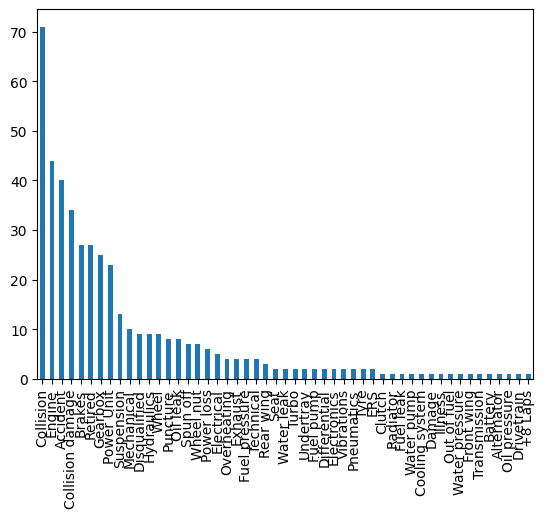

In [764]:
race_non_ended["status"].value_counts().plot(kind = "bar");

The races that do not contain position info are for drivers that were not able to finish the race for different reasons.
Observing at data in "race_non_ended" we can check that the hole data with lack of position, is data from drivers that could not end the race for diverse reasons. In order to  not to delete the data from our dataset, I will consider the position of the drivers that could not end the race as the position at the time of the failure, taking the info from table "lap_times"

In [765]:
lap_times = pd.read_csv('./data/csv_ergast_data/lap_times.csv')
df = pd.merge(race_non_ended, lap_times, how="left", on=["raceId", "driverId"])
columns=list(race_non_ended.columns)
columns.pop(list(race_non_ended.columns).index("position"))
df = df[df['laps']==df['lap']] #laps are the total laps for a driver and a race; in laps_pitstops I have the position per lap. Then will keep that position for the driver as his final result.
df = df[columns + ["position_y"]].rename(columns={"position_y":"position"}).drop(columns=["statusId", "status"])
df.shape

(432, 44)

In [766]:
df.head()

,raceId,driverId,ps_avg_ms,total_pit_stops,year,round,circuitId,constructorId,stint_1_hard,stint_2_medium,stint_3_hard,stint_1_medium,stint_2_hard,constructorRef,circuitRef,stint_4_soft,stint_3_medium,stint_4_medium,stint_1_soft,stint_3_soft,stint_2_soft,stint_4_hard,stint_5_soft,stint_5_medium,stint_5_hard,stint_6_hard,stint_2_intermediate,stint_3_intermediate,stint_4_intermediate,stint_5_intermediate,stint_6_wet,stint_1_wet,stint_2_wet,stint_3_wet,stint_4_wet,stint_5_wet,stint_1_intermediate,stint_6_soft,stint_7_soft,stint_6_medium,grid,laps,driver_type,position
23,863,819,24020.0,1,2012,4,3,206,0.0,0.0,0.000000,0.0,0.0,marussia,bahrain,0.0,0.00,0.0,0.500000,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,24,2.0,18
48,863,813,22599.0,2,2012,4,3,3,0.0,0.0,0.000000,0.0,0.0,williams,bahrain,0.0,0.08,0.0,0.440000,0.0,0.480000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,25,1.0,20
70,864,39,22016.5,2,2012,5,4,164,0.0,0.0,0.000000,0.0,0.0,hrt,catalunya,0.0,0.00,0.0,0.500000,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,22,2.0,21
105,864,819,21137.0,2,2012,5,4,206,0.0,0.0,0.228571,0.0,0.0,marussia,catalunya,0.0,0.00,0.0,0.428571,0.0,0.342857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,35,2.0,20
117,864,30,20113.0,1,2012,5,4,131,0.0,0.0,0.000000,0.0,0.0,mercedes,catalunya,0.0,0.00,0.0,0.833333,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,12,3.0,9


In [767]:
df_ml = df_ml.loc[~(df_ml["position"] == r"\N")] #discarding the rows with no position data
print(df_ml.shape)
df_ml = pd.concat([df_ml, df]) #concatenating with values where the position data was taken from lap_times table
df_ml.shape

(3745, 44)


(4177, 44)

In [768]:
df_ml.raceId.nunique()

188

In [769]:
df_ml.circuitRef.unique()

array(['bahrain', 'catalunya', 'monaco', 'villeneuve', 'valencia',
       'silverstone', 'hockenheimring', 'spa', 'monza', 'marina_bay',
       'suzuka', 'yeongam', 'buddh', 'yas_marina', 'americas',
       'interlagos', 'albert_park', 'sepang', 'shanghai', 'nurburgring',
       'hungaroring', 'red_bull_ring', 'sochi', 'baku', 'rodriguez',
       'ricard', 'portimao', 'imola', 'istanbul', 'zandvoort', 'losail',
       'jeddah', 'miami'], dtype=object)

### Circuit information

In [770]:
circuits_info = pd.read_csv("./data/outputs/final_circuit_data_output.csv")

In [771]:
circuits_info.head()

,Unnamed: 0,type,lap_lenght,full_throttle,longest_straight,downforce_level,longest_straight/lap
0,yas_marina,race,5.554,63.0,1.233,3,0.222002
1,albert_park,street,5.278,69.0,0.750,4,0.142099
2,red_bull_ring,street,4.326,79.0,0.868,3,0.200647
3,sochi,race,5.848,75.0,1.073,4,0.183482
4,baku,street,6.003,75.0,2.010,2,0.334833


In [772]:
circuits_info = circuits_info.rename(columns = {"longest_straight/lap": "rel_longest_straight", 'Unnamed: 0':"circuitRef", 'type': 'circuit_type'})

In [773]:
circuits_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   circuitRef            33 non-null     object 
 1   circuit_type          33 non-null     object 
 2   lap_lenght            33 non-null     float64
 3   full_throttle         33 non-null     float64
 4   longest_straight      33 non-null     float64
 5   downforce_level       33 non-null     int64  
 6   rel_longest_straight  33 non-null     float64
dtypes: float64(4), int64(1), object(2)
memory usage: 1.9+ KB


In [774]:
circuits_info.describe()

,lap_lenght,full_throttle,longest_straight,downforce_level,rel_longest_straight
count,33.000000,33.000000,33.000000,33.000000,33.000000
mean,5.203848,65.015152,1.125909,3.272727,0.216985
std,0.725212,9.814279,0.301170,0.977008,0.048624
min,3.337000,45.000000,0.669000,1.000000,0.129175
25%,4.653000,59.000000,0.969000,3.000000,0.183482
50%,5.400000,66.000000,1.073000,3.000000,0.207259
75%,5.621000,70.000000,1.205000,4.000000,0.256283
max,7.004000,84.000000,2.015000,5.000000,0.334833


In [775]:
circuits_info.drop(columns=["longest_straight"], inplace=True)

In [776]:
df_ml.circuitId.nunique()

33

In [777]:
df_ml.raceId.nunique()

188

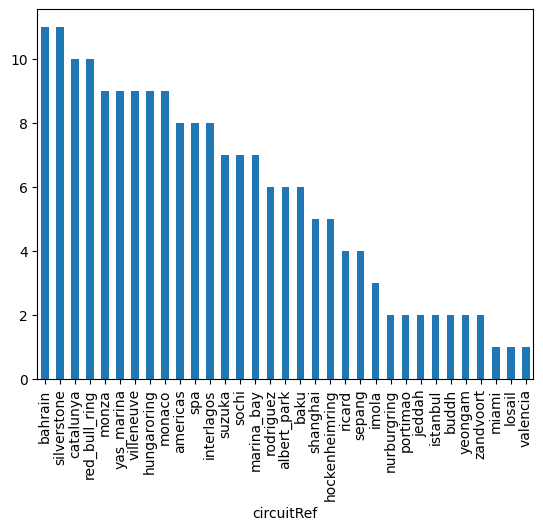

In [778]:
df_ml.groupby("circuitRef").raceId.nunique().sort_values(ascending=False).plot(kind="bar");

In [779]:
df_ml = pd.merge(df_ml, circuits_info, on="circuitRef", how='left')

In [780]:
pd.options.display.max_columns = 25

In [781]:
df_ml.circuitId.nunique()

33

### Dataset pre-treatment for machine learning

In [782]:
df_ml.columns

Index(['raceId', 'driverId', 'ps_avg_ms', 'total_pit_stops', 'year', 'round',
       'circuitId', 'constructorId', 'stint_1_hard', 'stint_2_medium',
       'stint_3_hard', 'stint_1_medium', 'stint_2_hard', 'constructorRef',
       'circuitRef', 'stint_4_soft', 'stint_3_medium', 'stint_4_medium',
       'stint_1_soft', 'stint_3_soft', 'stint_2_soft', 'stint_4_hard',
       'stint_5_soft', 'stint_5_medium', 'stint_5_hard', 'stint_6_hard',
       'stint_2_intermediate', 'stint_3_intermediate', 'stint_4_intermediate',
       'stint_5_intermediate', 'stint_6_wet', 'stint_1_wet', 'stint_2_wet',
       'stint_3_wet', 'stint_4_wet', 'stint_5_wet', 'stint_1_intermediate',
       'stint_6_soft', 'stint_7_soft', 'stint_6_medium', 'grid', 'position',
       'laps', 'driver_type', 'circuit_type', 'lap_lenght', 'full_throttle',
       'downforce_level', 'rel_longest_straight'],
      dtype='object')

In [783]:
df_ml[pd.isnull(df_ml)].sum()

raceId                  0.0
driverId                0.0
ps_avg_ms               0.0
total_pit_stops         0.0
year                    0.0
round                   0.0
circuitId               0.0
constructorId           0.0
stint_1_hard            0.0
stint_2_medium          0.0
stint_3_hard            0.0
stint_1_medium          0.0
stint_2_hard            0.0
constructorRef            0
circuitRef                0
stint_4_soft            0.0
stint_3_medium          0.0
stint_4_medium          0.0
stint_1_soft            0.0
stint_3_soft            0.0
stint_2_soft            0.0
stint_4_hard            0.0
stint_5_soft            0.0
stint_5_medium          0.0
stint_5_hard            0.0
stint_6_hard            0.0
stint_2_intermediate    0.0
stint_3_intermediate    0.0
stint_4_intermediate    0.0
stint_5_intermediate    0.0
stint_6_wet             0.0
stint_1_wet             0.0
stint_2_wet             0.0
stint_3_wet             0.0
stint_4_wet             0.0
stint_5_wet         

pre-treatment will be the one-hot encoding of the categorial data: constructor, driver type, and circuit type.

In [917]:
df = df_ml.copy()
# get dummies
df_dum = pd.get_dummies(df, columns = ['constructorRef', 'driver_type', "circuit_type"])

In [918]:
df_dum[df_dum.year == 2022].raceId.nunique()

22

In [919]:
df_dum[pd.isnull(df_dum['lap_lenght'])].circuitRef.unique()

array([], dtype=object)

In [920]:
print(df_ml.shape)
df_ml.drop_duplicates(inplace=True)
print(df_ml.shape)

(3848, 49)
(3848, 49)


## Machine Learning modelling

### preparation and standarization of data

In [921]:
df_dum["position"] = df_dum["position"].astype("int64")
# podium will be the target to train the models
df_dum["podium"] = df_dum.position.map(lambda x: 1 if x in [1,2,3] else 0)

train = df_dum[df_dum.year <2022] ## keep 2022 for prediction
X_train = train.drop(['raceId', 'driverId', "circuitId", "constructorId","position",'podium', 'circuitRef'], axis = 1)
y_train = train["podium"]
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

In [922]:
train.raceId.nunique()

166

In [898]:
X_train.columns

Index(['ps_avg_ms', 'total_pit_stops', 'year', 'round', 'stint_1_hard',
       'stint_2_medium', 'stint_3_hard', 'stint_1_medium', 'stint_2_hard',
       'stint_4_soft', 'stint_3_medium', 'stint_4_medium', 'stint_1_soft',
       'stint_3_soft', 'stint_2_soft', 'stint_4_hard', 'stint_5_soft',
       'stint_5_medium', 'stint_5_hard', 'stint_6_hard',
       'stint_2_intermediate', 'stint_3_intermediate', 'stint_4_intermediate',
       'stint_5_intermediate', 'stint_6_wet', 'stint_1_wet', 'stint_2_wet',
       'stint_3_wet', 'stint_4_wet', 'stint_5_wet', 'stint_1_intermediate',
       'stint_6_soft', 'stint_7_soft', 'stint_6_medium', 'grid', 'laps',
       'lap_lenght', 'full_throttle', 'downforce_level',
       'rel_longest_straight', 'constructorRef_alfa',
       'constructorRef_alphatauri', 'constructorRef_alpine',
       'constructorRef_aston_martin', 'constructorRef_caterham',
       'constructorRef_ferrari', 'constructorRef_force_india',
       'constructorRef_haas', 'constructorRef_

In [923]:
df_dum[df_dum["year"] == 2022].raceId.nunique()

22

The proportion of labels 1 (podium) vs 0 (no podium) is 16 % 

In [871]:
len(y_train[y_train ==1])/len(y_train)

0.1563049853372434

### Model trainings and evaluation

In [793]:
import numpy as np
import pandas as pd
from sklearn.metrics import  precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import warnings
np.set_printoptions(precision=4)
warnings.filterwarnings(action='once')

In [794]:
def score_classification(model):
    
    precision = 0
    roc_AUC = 0
    for race in df_dum[df_dum.year == 2022]['round'].unique():

        #samples from season 2022
        test = df_dum[(df_dum.year == 2022) & (df_dum['round'] == race)]
        
        X_test = test.drop(['raceId', 'driverId', "circuitId", "constructorId","position",'podium', 'circuitRef'], axis = 1)
        y_test = test["podium"]
        #print(y_test)
        #scaling
        X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

        # make predictions
        prediction_df = pd.DataFrame(model.predict_proba(X_test), columns = ['proba_0', 'proba_1'])

        #print(prediction_df)
        prediction_df['actual'] = y_test.reset_index(drop = True)
        #print(prediction_df)
        prediction_df.sort_values('proba_1', ascending = False, inplace = True)
        #print(prediction_df)
        prediction_df.reset_index(inplace = True, drop = True)
        #print(prediction_df)
        prediction_df['predicted'] = prediction_df.index
        #print(prediction_df)
        prediction_df['predicted'] = prediction_df.predicted.map(lambda x: 1 if x in [0,1,2] else 0)
        #print(prediction_df)
        
        precision += precision_score(prediction_df.actual, prediction_df.predicted)
        roc_AUC += roc_auc_score(prediction_df.actual, prediction_df.proba_1)

    
    precision_score_f = precision/df_dum[df_dum.year == 2022]['round'].unique().max()
    roc_auc_score_f = roc_AUC/df_dum[df_dum.year == 2022]['round'].unique().max()
    
    return precision_score_f,roc_auc_score_f

In [795]:
def feature_importance(model, model_name):

    fi = np.array(model.feature_importances_)

    fn = np.array(model.feature_names_in_)

    data={'feature_names':fn,'feature_importance':fi}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace = True)
    #Define size of bar plot
    plt.figure(figsize=(15,12))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(f"{model_name}" + ' FEATURE IMPORTANCE')
    plt.rcParams.update({'font.size':10})
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

Keep all the results in memory:

In [798]:
comparison_dict = {'model':[],
                  'params': [],
                  'precision_score': [],
                  'roc_AUC_score':[]}

I will separatelly save the scores of the chosen models in test from the models iterated:

In [799]:
specific_models = pd.DataFrame(columns=['model','params','precision_score', 'roc_AUC_score'])

In [800]:
#saving the scores for 20 iterations per model for better representation
chosen_models_repetition = {'model':[],
                  'params': [],
                  'precision_score': [],
                  'roc_AUC_score':[]}

#### Logistic Regression

In [801]:
# logistic classification
params={'penalty': ['l1', 'l2'],
        'solver': ['saga', 'liblinear'],
        'C': np.logspace(-3,1,20)}

for penalty in params['penalty']:
    for solver in params['solver']:
        for c in params['C']:
            model_params = (penalty, solver, c)
            model = LogisticRegression(penalty = penalty, solver = solver, C = c, max_iter = 10000,class_weight="balanced", random_state=42)
            model.fit(X_train, y_train)
            precision_score_f,roc_auc_score_f = score_classification(model)
            print(f"fitting lr with penalty: {penalty}, solver: {solver}, C: {c}, precision_score:{precision_score_f}, roc_AUC_score: {roc_auc_score_f}")
            
            comparison_dict['model'].append('logistic_regression')
            comparison_dict['params'].append(model_params)
            comparison_dict['precision_score'].append(precision_score_f)
            comparison_dict['roc_AUC_score'].append(roc_auc_score_f)

fitting lr with penalty: l1, solver: saga, C: 0.001, precision_score:0.606060606060606, roc_AUC_score: 0.8969381829866934
fitting lr with penalty: l1, solver: saga, C: 0.001623776739188721, precision_score:0.5454545454545454, roc_AUC_score: 0.8969647199351911
fitting lr with penalty: l1, solver: saga, C: 0.0026366508987303583, precision_score:0.5606060606060604, roc_AUC_score: 0.8989168093108866
fitting lr with penalty: l1, solver: saga, C: 0.004281332398719396, precision_score:0.5757575757575757, roc_AUC_score: 0.9061389402913036
fitting lr with penalty: l1, solver: saga, C: 0.0069519279617756054, precision_score:0.606060606060606, roc_AUC_score: 0.9270552108399271
fitting lr with penalty: l1, solver: saga, C: 0.011288378916846888, precision_score:0.6363636363636362, roc_AUC_score: 0.9308987937276275
fitting lr with penalty: l1, solver: saga, C: 0.018329807108324356, precision_score:0.6666666666666665, roc_AUC_score: 0.9349400314348318
fitting lr with penalty: l1, solver: saga, C: 0.0

In [ ]:
params={'penalty': ['l2', None],
        'solver': ['lbfgs', 'newton-cg','newton-cholesky','sag'],
        'C': np.logspace(-3,1,20)}

for penalty in params['penalty']:
    for solver in params['solver']:
        for c in params['C']:
            model_params = (penalty, solver, c)
            model = LogisticRegression(penalty = penalty, solver = solver, C = c, max_iter = 10000,class_weight="balanced", random_state=42)
            model.fit(X_train, y_train)
            precision_score_f,roc_auc_score_f = score_classification(model)
            print(f"fitting lr with penalty: {penalty}, solver: {solver}, C: {c}, precision_score:{precision_score_f}, roc_AUC_score: {roc_auc_score_f}")
            
            comparison_dict['model'].append('logistic_regression')
            comparison_dict['params'].append(model_params)
            comparison_dict['precision_score'].append(precision_score_f)
            comparison_dict['roc_AUC_score'].append(roc_auc_score_f)

In [803]:
#select the best based in the scores
df = pd.DataFrame(comparison_dict)
df = df[(df['model'] == 'logistic_regression')]
df.to_csv("./data/outputs/random_forest_results.csv")
best_models_prec = df[df["precision_score"] ==df["precision_score"].max()]
best_models_roc = df[df["roc_AUC_score"] ==df["roc_AUC_score"].max()]

In [804]:
specific_models = pd.concat([specific_models,best_models_roc,best_models_prec])

In [805]:
specific_models[specific_models['model'] == 'logistic_regression'].drop_duplicates()

,model,params,precision_score,roc_AUC_score
67,logistic_regression,"(l2, liblinear, 0.029763514416313176)",0.666667,0.941513
43,logistic_regression,"(l2, saga, 0.004281332398719396)",0.681818,0.938565
83,logistic_regression,"(l2, lbfgs, 0.004281332398719396)",0.681818,0.938565
103,logistic_regression,"(l2, newton-cg, 0.004281332398719396)",0.681818,0.938565
123,logistic_regression,"(l2, newton-cholesky, 0.004281332398719396)",0.681818,0.938565
143,logistic_regression,"(l2, sag, 0.004281332398719396)",0.681818,0.938565


The better result using the standarized data:

In [806]:
penalty="l2"
solver="saga"
c= 0.004281332398719396

for _ in range(20):
    model_params = (penalty, solver, c)
    model = LogisticRegression(penalty = penalty, solver = solver, C = c, max_iter = 10000,class_weight="balanced")
    model.fit(X_train, y_train)
    precision_score_f,roc_auc_score_f = score_classification(model)
    print(f"fitting lr with penalty: {penalty}, solver: {solver}, C: {c}, precision_score:{precision_score_f}, roc_AUC_score: {roc_auc_score_f}")

    chosen_models_repetition['model'].append('logistic_regression')
    chosen_models_repetition['params'].append(model_params)
    chosen_models_repetition['precision_score'].append(precision_score_f)
    chosen_models_repetition['roc_AUC_score'].append(roc_auc_score_f)

fitting lr with penalty: l2, solver: saga, C: 0.004281332398719396, precision_score:0.6818181818181818, roc_AUC_score: 0.9385647503025027
fitting lr with penalty: l2, solver: saga, C: 0.004281332398719396, precision_score:0.6818181818181818, roc_AUC_score: 0.9385647503025027
fitting lr with penalty: l2, solver: saga, C: 0.004281332398719396, precision_score:0.6818181818181818, roc_AUC_score: 0.9385647503025027
fitting lr with penalty: l2, solver: saga, C: 0.004281332398719396, precision_score:0.6818181818181818, roc_AUC_score: 0.9385647503025027
fitting lr with penalty: l2, solver: saga, C: 0.004281332398719396, precision_score:0.6818181818181818, roc_AUC_score: 0.9385647503025027
fitting lr with penalty: l2, solver: saga, C: 0.004281332398719396, precision_score:0.6818181818181818, roc_AUC_score: 0.9385647503025027
fitting lr with penalty: l2, solver: saga, C: 0.004281332398719396, precision_score:0.6818181818181818, roc_AUC_score: 0.9385647503025027
fitting lr with penalty: l2, solve

In [807]:
coef_per_feature = pd.concat([pd.DataFrame(model.feature_names_in_, columns = ["features"]), pd.DataFrame(model.coef_.T, columns = ["model_coefficients"])], axis=1, sort=True)
coef_per_feature.sort_values(by="model_coefficients", ascending=False)

,features,model_coefficients
53,constructorRef_mercedes,0.356237
55,constructorRef_red_bull,0.335094
60,driver_type_0.0,0.289679
63,driver_type_3.0,0.275546
45,constructorRef_ferrari,0.263251
35,laps,0.188474
49,constructorRef_lotus_f1,0.167161
36,lap_lenght,0.094237
6,stint_3_hard,0.057885
31,stint_6_soft,0.052964


In [845]:
coef_per_feature.to_csv("./data/outputs/logistic_coefficients.csv")

+ Driver group references --> descending from best to worst categories
+ Group Juan Manuel Fangio (Elite) --> is driver type 3
+ Group Frnando Alonso (Fernando Alonso) --> is driver type 0
+ Group runner-ups (Nicolas Hulkenberg) --> is driver type 4
+ Group Russell --> is driver type 1
+ Group Brabham --> is driver type 2

#### Support Vector Machine Classiffier

In [808]:
params = {'gamma': np.logspace(-4, -1, 20),
        'C': np.logspace(-2, 1, 20),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 

for gamma in params['gamma']:
    for c in params['C']:
        for kernel in params['kernel']:
            model_params = (gamma, c, kernel)
            model = svm.SVC(probability = True, gamma = gamma, C = c, kernel = kernel, class_weight={0:0.84,1:0.16})
            
            model.fit(X_train, y_train)
            precision_score_f,roc_auc_score_f = score_classification(model)
            print(f"fitting svm with gamma: {gamma}, C: {c}, kernel: {kernel}, precision_score:{precision_score_f}, roc_AUC_score: {roc_auc_score_f}")
            
            comparison_dict['model'].append('svm_classifier')
            comparison_dict['params'].append(model_params)
            comparison_dict['precision_score'].append(precision_score_f)
            comparison_dict['roc_AUC_score'].append(roc_auc_score_f)

fitting lr with gamma: 0.0001, C: 0.01, kernel: linear, precision_score:0.5606060606060606, roc_AUC_score: 0.8773559757147329
fitting lr with gamma: 0.0001, C: 0.01, kernel: poly, precision_score:0.37878787878787873, roc_AUC_score: 0.8105822632083136
fitting lr with gamma: 0.0001, C: 0.01, kernel: rbf, precision_score:0.4090909090909091, roc_AUC_score: 0.8489233020291264
fitting lr with gamma: 0.0001, C: 0.01, kernel: sigmoid, precision_score:0.5606060606060606, roc_AUC_score: 0.8747926321066061
fitting lr with gamma: 0.0001, C: 0.01438449888287663, kernel: linear, precision_score:0.5606060606060604, roc_AUC_score: 0.8888361205882277
fitting lr with gamma: 0.0001, C: 0.01438449888287663, kernel: poly, precision_score:0.0, roc_AUC_score: 0.19049805406033382
fitting lr with gamma: 0.0001, C: 0.01438449888287663, kernel: rbf, precision_score:0.4090909090909091, roc_AUC_score: 0.8489233020291264
fitting lr with gamma: 0.0001, C: 0.01438449888287663, kernel: sigmoid, precision_score:0.56060

In [809]:
#selecting the best models
df = pd.DataFrame(comparison_dict)
df = df[(df['model'] == 'svm_classifier')]
df.to_csv("./data/outputs/svm_classifier.csv")
best_models_prec = df[df["precision_score"] ==df["precision_score"].max()]
best_models_roc = df[df["roc_AUC_score"] ==df["roc_AUC_score"].max()]

In [810]:
specific_models = pd.concat([specific_models,best_models_roc,best_models_prec])

In [811]:
pd.options.display.max_colwidth = 70

In [812]:
specific_models[specific_models['model'] == 'svm_classifier'].drop_duplicates()

,model,params,precision_score,roc_AUC_score
963,svm_classifier,"(0.0026366508987303583, 0.01, sigmoid)",0.696970,0.93943
971,svm_classifier,"(0.0026366508987303583, 0.0206913808111479, sigmoid)",0.712121,0.92733


In [813]:
for _ in range(20):
    model_params = (0.0026366508987303583, 0.0206913808111479, 'sigmoid')
    model = svm.SVC(probability = True, gamma = 0.0026366508987303583, C =  0.0206913808111479, kernel = 'sigmoid', class_weight={0:0.84,1:0.16})

    model.fit(X_train, y_train)
    precision_score_f,roc_auc_score_f = score_classification(model)
    print(f" precision_score:{precision_score_f}, roc_AUC_score: {roc_auc_score_f}")

    chosen_models_repetition['model'].append('svm_classifier')
    chosen_models_repetition['params'].append(model_params)
    chosen_models_repetition['precision_score'].append(precision_score_f)
    chosen_models_repetition['roc_AUC_score'].append(roc_auc_score_f)

 precision_score:0.712121212121212, roc_AUC_score: 0.92732994942697
 precision_score:0.712121212121212, roc_AUC_score: 0.92732994942697
 precision_score:0.712121212121212, roc_AUC_score: 0.92732994942697
 precision_score:0.712121212121212, roc_AUC_score: 0.92732994942697
 precision_score:0.712121212121212, roc_AUC_score: 0.92732994942697
 precision_score:0.712121212121212, roc_AUC_score: 0.92732994942697
 precision_score:0.712121212121212, roc_AUC_score: 0.92732994942697
 precision_score:0.712121212121212, roc_AUC_score: 0.92732994942697
 precision_score:0.712121212121212, roc_AUC_score: 0.92732994942697
 precision_score:0.712121212121212, roc_AUC_score: 0.92732994942697
 precision_score:0.712121212121212, roc_AUC_score: 0.92732994942697
 precision_score:0.712121212121212, roc_AUC_score: 0.92732994942697
 precision_score:0.712121212121212, roc_AUC_score: 0.92732994942697
 precision_score:0.712121212121212, roc_AUC_score: 0.92732994942697
 precision_score:0.712121212121212, roc_AUC_scor

#### Random Forest Classifier

In [924]:
#random forest classifier

params={'criterion': ['gini', 'entropy'],
        'max_features': [0.8, None],
        'max_depth': list(np.linspace(5, 55, 26, dtype=int)) + [None]}

for criterion in params['criterion']:
    for max_features in params['max_features']:
        for max_depth in params['max_depth']:
            model_params = (criterion, max_features, max_depth)
            model = RandomForestClassifier(criterion = criterion, max_features = max_features, max_depth = max_depth)
            model.fit(X_train, y_train)
            precision_score_f,roc_auc_score_f = score_classification(model)
            print(f"fitting rf with criterion: {criterion}, max_features: {max_features}, max_depth: {max_depth},\
                                precision_score:{precision_score_f}, roc_AUC_score: {roc_auc_score_f}")
                
            comparison_dict['model'].append('random_forest_classifier_final')
            comparison_dict['params'].append(model_params)
            comparison_dict['precision_score'].append(precision_score_f)
            comparison_dict['roc_AUC_score'].append(roc_auc_score_f)

fitting rf with criterion: gini, max_features: 0.8, max_depth: 5,                                precision_score:0.6818181818181817, roc_AUC_score: 0.9363853652289482
fitting rf with criterion: gini, max_features: 0.8, max_depth: 7,                                precision_score:0.6666666666666665, roc_AUC_score: 0.9314925753094204
fitting rf with criterion: gini, max_features: 0.8, max_depth: 9,                                precision_score:0.6363636363636362, roc_AUC_score: 0.9262360374325617
fitting rf with criterion: gini, max_features: 0.8, max_depth: 11,                                precision_score:0.621212121212121, roc_AUC_score: 0.9253579308392144
fitting rf with criterion: gini, max_features: 0.8, max_depth: 13,                                precision_score:0.6363636363636362, roc_AUC_score: 0.9254223160974498
fitting rf with criterion: gini, max_features: 0.8, max_depth: 15,                                precision_score:0.6515151515151514, roc_AUC_score: 0.9232458124169

In [926]:
df = pd.DataFrame(comparison_dict)
df = df[(df['model'] == 'random_forest_classifier_final')]
df.to_csv("./data/outputs/random_forest_results_final.csv")
best_models_prec = df[df["precision_score"] ==df["precision_score"].max()]
best_models_roc = df[df["roc_AUC_score"] ==df["roc_AUC_score"].max()]

In [927]:
specific_models = pd.concat([specific_models,best_models_prec,best_models_roc])

In [928]:
specific_models[specific_models["model"]=="random_forest_classifier_final"].drop_duplicates()

,model,params,precision_score,roc_AUC_score
2764,random_forest_classifier_final,"(entropy, None, 29)",0.712121,0.933979
2698,random_forest_classifier_final,"(gini, None, 5)",0.696970,0.936562


In [929]:
model_params = ("entropy",None,29)
model = RandomForestClassifier(criterion = "entropy", max_features = None, max_depth = 29)
model.fit(X_train, y_train)
precision_score_f,roc_auc_score_f = score_classification(model)
print(f"fitting rf precision_score:{precision_score_f}, roc_AUC_score: {roc_auc_score_f}")


chosen_models_repetition['model'].append('random_forest_classifier_final')
chosen_models_repetition['params'].append(model_params)
chosen_models_repetition['precision_score'].append(precision_score_f)
chosen_models_repetition['roc_AUC_score'].append(roc_auc_score_f)

fitting rf precision_score:0.6818181818181817, roc_AUC_score: 0.9263723965428512


In [930]:
fi = np.array(model.feature_importances_)

fn = np.array(model.feature_names_in_)

data={'feature_names':fn,'feature_importance':fi}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False, inplace = True)

In [931]:
fi_df

,feature_names,feature_importance
34,grid,0.454905
0,ps_avg_ms,0.059470
12,stint_1_soft,0.033437
5,stint_2_medium,0.031401
2,year,0.031047
7,stint_1_medium,0.028449
35,laps,0.027633
3,round,0.026490
39,rel_longest_straight,0.024981
8,stint_2_hard,0.022206


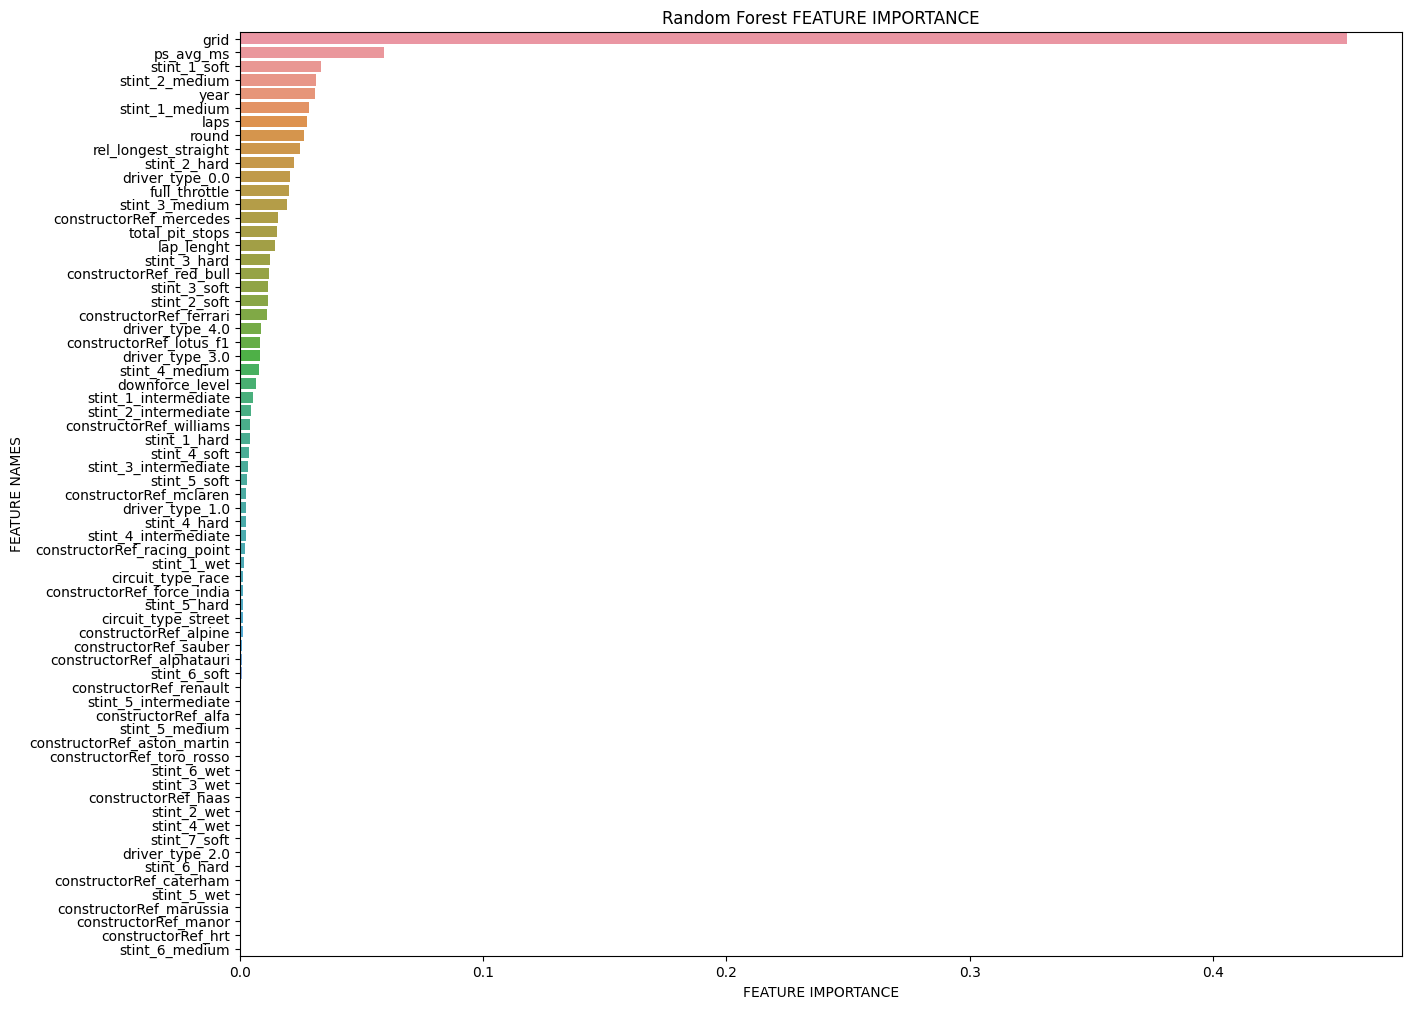

In [932]:
feature_importance(model,"Random Forest")

dropping the features without importance

In [933]:
to_drop = fi_df[fi_df['feature_importance'] == 0.000000].feature_names.values

In [934]:
to_drop

array(['constructorRef_caterham', 'stint_5_wet',
       'constructorRef_marussia', 'constructorRef_manor',
       'constructorRef_hrt', 'stint_6_medium'], dtype=object)

In [935]:
df_dum.drop(columns = to_drop, inplace=True)

In [936]:
df_dum.columns

Index(['raceId', 'driverId', 'ps_avg_ms', 'total_pit_stops', 'year', 'round',
       'circuitId', 'constructorId', 'stint_1_hard', 'stint_2_medium',
       'stint_3_hard', 'stint_1_medium', 'stint_2_hard', 'circuitRef',
       'stint_4_soft', 'stint_3_medium', 'stint_4_medium', 'stint_1_soft',
       'stint_3_soft', 'stint_2_soft', 'stint_4_hard', 'stint_5_soft',
       'stint_5_medium', 'stint_5_hard', 'stint_6_hard',
       'stint_2_intermediate', 'stint_3_intermediate', 'stint_4_intermediate',
       'stint_5_intermediate', 'stint_6_wet', 'stint_1_wet', 'stint_2_wet',
       'stint_3_wet', 'stint_4_wet', 'stint_1_intermediate', 'stint_6_soft',
       'stint_7_soft', 'grid', 'position', 'laps', 'lap_lenght',
       'full_throttle', 'downforce_level', 'rel_longest_straight',
       'constructorRef_alfa', 'constructorRef_alphatauri',
       'constructorRef_alpine', 'constructorRef_aston_martin',
       'constructorRef_ferrari', 'constructorRef_force_india',
       'constructorRef_haas'

Repeating training process without those columns

In [937]:
df_dum["position"] = df_dum["position"].astype("int64")
# podium will be the target to train the models
df_dum["podium"] = df_dum.position.map(lambda x: 1 if x in [1,2,3] else 0)

train = df_dum[df_dum.year <2022] ## keep 2022 for prediction
X_train = train.drop(['raceId', 'driverId', "circuitId", "constructorId","position",'podium', 'circuitRef'], axis = 1)
y_train = train["podium"]
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

In [938]:
#random forest classifier

params={'criterion': ['gini', 'entropy'],
        'max_features': [0.8, None],
        'max_depth': list(np.linspace(5, 55, 26, dtype=int)) + [None]}

for criterion in params['criterion']:
    for max_features in params['max_features']:
        for max_depth in params['max_depth']:
            model_params = (criterion, max_features, max_depth)
            model = RandomForestClassifier(criterion = criterion, max_features = max_features, max_depth = max_depth)
            model.fit(X_train, y_train)
            precision_score_f,roc_auc_score_f = score_classification(model)
            print(f"fitting rf with criterion: {criterion}, max_features: {max_features}, max_depth: {max_depth},\
                                precision_score:{precision_score_f}, roc_AUC_score: {roc_auc_score_f}")
            
            comparison_dict['model'].append('random_forest_classifier_columns_deleted_final')
            comparison_dict['params'].append(model_params)
            comparison_dict['precision_score'].append(precision_score_f)
            comparison_dict['roc_AUC_score'].append(roc_auc_score_f)

fitting rf with criterion: gini, max_features: 0.8, max_depth: 5,                                precision_score:0.6818181818181817, roc_AUC_score: 0.9345768387880689
fitting rf with criterion: gini, max_features: 0.8, max_depth: 7,                                precision_score:0.6363636363636362, roc_AUC_score: 0.9298155127700583
fitting rf with criterion: gini, max_features: 0.8, max_depth: 9,                                precision_score:0.621212121212121, roc_AUC_score: 0.9263117972342573
fitting rf with criterion: gini, max_features: 0.8, max_depth: 11,                                precision_score:0.621212121212121, roc_AUC_score: 0.9250918051051741
fitting rf with criterion: gini, max_features: 0.8, max_depth: 13,                                precision_score:0.6666666666666665, roc_AUC_score: 0.9249389443741051
fitting rf with criterion: gini, max_features: 0.8, max_depth: 15,                                precision_score:0.6212121212121211, roc_AUC_score: 0.92305739974523

In [939]:
df = pd.DataFrame(comparison_dict)
df = df[(df['model'] == 'random_forest_classifier_columns_deleted_final')]
df.to_csv("./data/outputs/random_forest_classifier_columns_deleted_final.csv")
best_models_prec = df[df["precision_score"] ==df["precision_score"].max()]
best_models_roc = df[df["roc_AUC_score"] ==df["roc_AUC_score"].max()]

In [940]:
specific_models = pd.concat([specific_models,best_models_prec,best_models_roc])

In [941]:
specific_models[specific_models["model"]=="random_forest_classifier_columns_deleted_final"].drop_duplicates()

,model,params,precision_score,roc_AUC_score
2807,random_forest_classifier_columns_deleted_final,"(gini, None, 7)",0.712121,0.935277
2806,random_forest_classifier_columns_deleted_final,"(gini, None, 5)",0.696970,0.943372


In [942]:
model_params = ("gini",None,7)
model = RandomForestClassifier(criterion = "gini", max_features = None, max_depth = 7)
model.fit(X_train, y_train)
precision_score_f,roc_auc_score_f = score_classification(model)
print(f"fitting rf precision_score:{precision_score_f}, roc_AUC_score: {roc_auc_score_f}")

chosen_models_repetition['model'].append('random_forest_classifier_columns_deleted_final')
chosen_models_repetition['params'].append(model_params)
chosen_models_repetition['precision_score'].append(precision_score_f)
chosen_models_repetition['roc_AUC_score'].append(roc_auc_score_f)

fitting rf precision_score:0.6666666666666665, roc_AUC_score: 0.9335327031851097


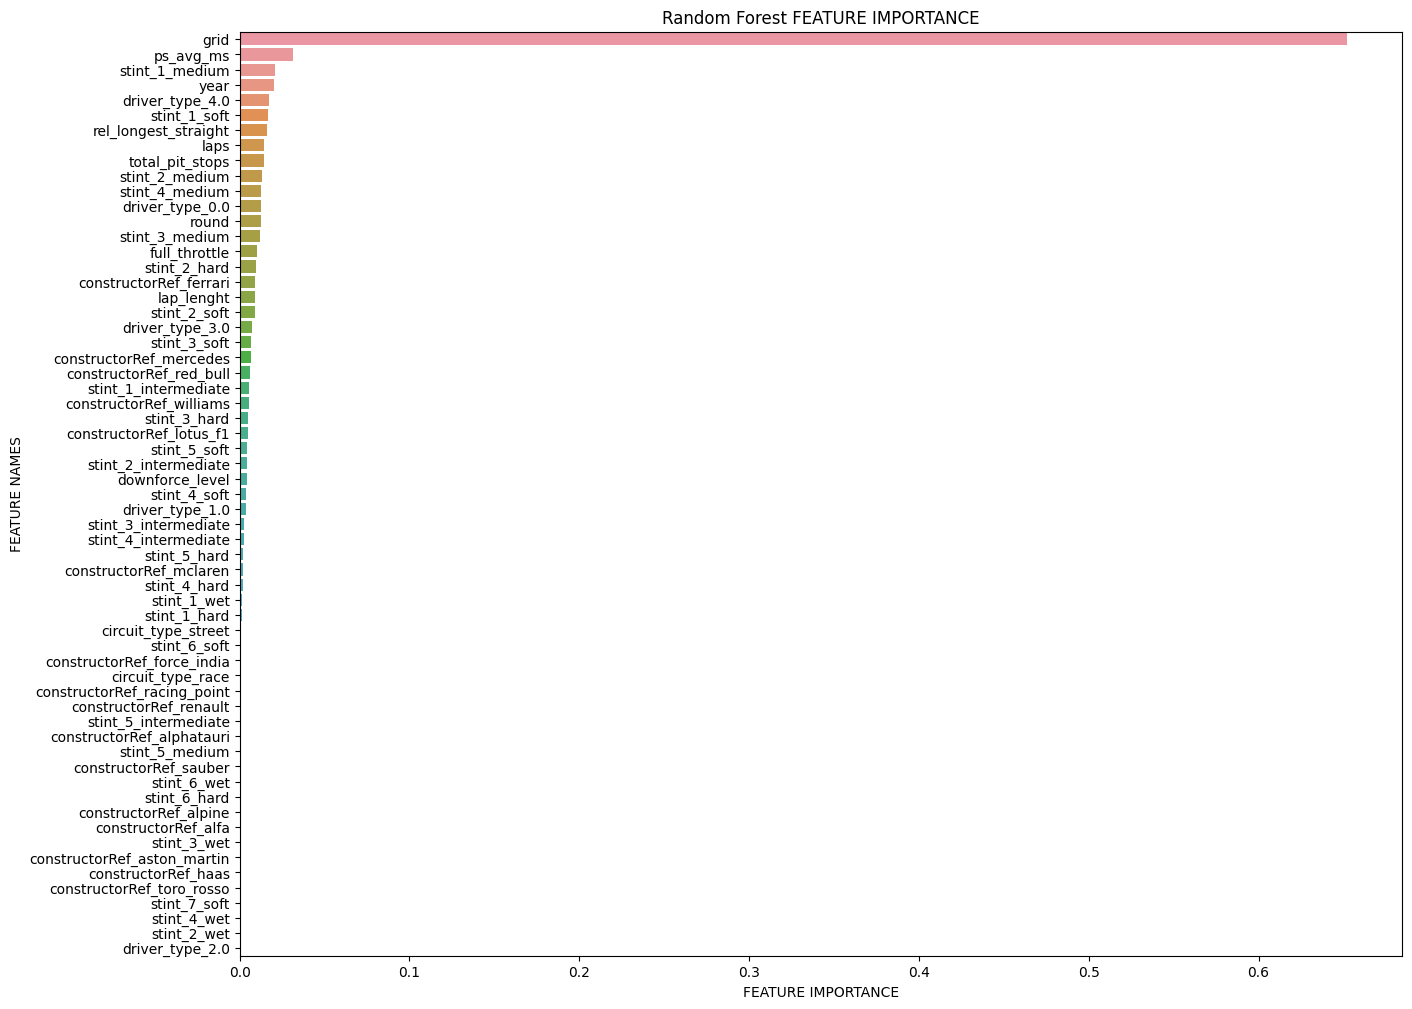

In [943]:
feature_importance(model=model, model_name="Random Forest")

Gradient Boosting

    loss : {'log_loss', 'deviance', 'exponential'}, default='log_loss'
        The loss function to be optimized. 'log_loss' refers to binomial and
        multinomial deviance, the same as used in logistic regression.
        It is a good choice for classification with probabilistic outputs.
        For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.

        .. deprecated:: 1.1
            The loss 'deviance' was deprecated in v1.1 and will be removed in
            version 1.3. Use `loss='log_loss'` which is equivalent.

    learning_rate : float, default=0.1
        Learning rate shrinks the contribution of each tree by `learning_rate`.
        There is a trade-off between learning_rate and n_estimators.
        Values must be in the range `[0.0, inf)`.

    n_estimators : int, default=100
        The number of boosting stages to perform. Gradient boosting
        is fairly robust to over-fitting so a large number usually
        results in better performance.
        Values must be in the range `[1, inf)`.

    subsample : float, default=1.0
        The fraction of samples to be used for fitting the individual base
        learners. If smaller than 1.0 this results in Stochastic Gradient
        Boosting. `subsample` interacts with the parameter `n_estimators`.
        Choosing `subsample < 1.0` leads to a reduction of variance
        and an increase in bias.
        Values must be in the range `(0.0, 1.0]`.

    criterion : {'friedman_mse', 'squared_error'}, default='friedman_mse'
        The function to measure the quality of a split. Supported criteria are
        'friedman_mse' for the mean squared error with improvement score by
        Friedman, 'squared_error' for mean squared error. The default value of
        'friedman_mse' is generally the best as it can provide a better
        approximation in some cases.

        .. versionadded:: 0.18

    min_samples_split : int or float, default=2
        The minimum number of samples required to split an internal node:

        - If int, values must be in the range `[2, inf)`.
        - If float, values must be in the range `(0.0, 1.0]` and `min_samples_split`
          will be `ceil(min_samples_split * n_samples)`.

        .. versionchanged:: 0.18
           Added float values for fractions.

    min_samples_leaf : int or float, default=1
        The minimum number of samples required to be at a leaf node.
        A split point at any depth will only be considered if it leaves at
        least ``min_samples_leaf`` training samples in each of the left and
        right branches.  This may have the effect of smoothing the model,
        especially in regression.

        - If int, values must be in the range `[1, inf)`.
        - If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf`
          will be `ceil(min_samples_leaf * n_samples)`.

        .. versionchanged:: 0.18
           Added float values for fractions.

    min_weight_fraction_leaf : float, default=0.0
        The minimum weighted fraction of the sum total of weights (of all
        the input samples) required to be at a leaf node. Samples have
        equal weight when sample_weight is not provided.
        Values must be in the range `[0.0, 0.5]`.

    max_depth : int or None, default=3
        Maximum depth of the individual regression estimators. The maximum
        depth limits the number of nodes in the tree. Tune this parameter
        for best performance; the best value depends on the interaction
        of the input variables. If None, then nodes are expanded until
        all leaves are pure or until all leaves contain less than
        min_samples_split samples.
        If int, values must be in the range `[1, inf)`.

    min_impurity_decrease : float, default=0.0
        A node will be split if this split induces a decrease of the impurity
        greater than or equal to this value.
        Values must be in the range `[0.0, inf)`.

        The weighted impurity decrease equation is the following::

            N_t / N * (impurity - N_t_R / N_t * right_impurity
                                - N_t_L / N_t * left_impurity)

        where ``N`` is the total number of samples, ``N_t`` is the number of
        samples at the current node, ``N_t_L`` is the number of samples in the
        left child, and ``N_t_R`` is the number of samples in the right child.

        ``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,
        if ``sample_weight`` is passed.

        .. versionadded:: 0.19

    init : estimator or 'zero', default=None
        An estimator object that is used to compute the initial predictions.
        ``init`` has to provide :meth:`fit` and :meth:`predict_proba`. If
        'zero', the initial raw predictions are set to zero. By default, a
        ``DummyEstimator`` predicting the classes priors is used.

    random_state : int, RandomState instance or None, default=None
        Controls the random seed given to each Tree estimator at each
        boosting iteration.
        In addition, it controls the random permutation of the features at
        each split (see Notes for more details).
        It also controls the random splitting of the training data to obtain a
        validation set if `n_iter_no_change` is not None.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.

    max_features : {'auto', 'sqrt', 'log2'}, int or float, default=None
        The number of features to consider when looking for the best split:

        - If int, values must be in the range `[1, inf)`.
        - If float, values must be in the range `(0.0, 1.0]` and the features
          considered at each split will be `max(1, int(max_features * n_features_in_))`.
        - If 'auto', then `max_features=sqrt(n_features)`.
        - If 'sqrt', then `max_features=sqrt(n_features)`.
        - If 'log2', then `max_features=log2(n_features)`.
        - If None, then `max_features=n_features`.

        Choosing `max_features < n_features` leads to a reduction of variance
        and an increase in bias.

        Note: the search for a split does not stop until at least one
        valid partition of the node samples is found, even if it requires to
        effectively inspect more than ``max_features`` features.

    verbose : int, default=0
        Enable verbose output. If 1 then it prints progress and performance
        once in a while (the more trees the lower the frequency). If greater
        than 1 then it prints progress and performance for every tree.
        Values must be in the range `[0, inf)`.

    max_leaf_nodes : int, default=None
        Grow trees with ``max_leaf_nodes`` in best-first fashion.
        Best nodes are defined as relative reduction in impurity.
        Values must be in the range `[2, inf)`.
        If `None`, then unlimited number of leaf nodes.

    warm_start : bool, default=False
        When set to ``True``, reuse the solution of the previous call to fit
        and add more estimators to the ensemble, otherwise, just erase the
        previous solution. See :term:`the Glossary <warm_start>`.

    validation_fraction : float, default=0.1
        The proportion of training data to set aside as validation set for
        early stopping. Values must be in the range `(0.0, 1.0)`.
        Only used if ``n_iter_no_change`` is set to an integer.

        .. versionadded:: 0.20

    n_iter_no_change : int, default=None
        ``n_iter_no_change`` is used to decide if early stopping will be used
        to terminate training when validation score is not improving. By
        default it is set to None to disable early stopping. If set to a
        number, it will set aside ``validation_fraction`` size of the training
        data as validation and terminate training when validation score is not
        improving in all of the previous ``n_iter_no_change`` numbers of
        iterations. The split is stratified.
        Values must be in the range `[1, inf)`.

        .. versionadded:: 0.20

    tol : float, default=1e-4
        Tolerance for the early stopping. When the loss is not improving
        by at least tol for ``n_iter_no_change`` iterations (if set to a
        number), the training stops.
        Values must be in the range `[0.0, inf)`.

        .. versionadded:: 0.20

    ccp_alpha : non-negative float, default=0.0
        Complexity parameter used for Minimal Cost-Complexity Pruning. The
        subtree with the largest cost complexity that is smaller than
        ``ccp_alpha`` will be chosen. By default, no pruning is performed.
        Values must be in the range `[0.0, inf)`.
        See :ref:`minimal_cost_complexity_pruning` for details.

In [833]:
X_train.shape

(3689, 61)

In [834]:

# params = {'learning_rate':[0.01, 0.015, 0.025, 0.05, 0.1],
# 'n_estimators':[10000],
# 'max_depth' :[3,5,8,15,25,30,None],
# 'min_samples_split':[2,5,7,11],
# 'criterion' :['friedman_mse', 'squared_error'],
# "subsample":[0.7, 0.8, 0.9, 1]}

# n=1
# for learning_rate in params['learning_rate']:
#     for n_estimators in params['n_estimators']:
#         for max_depth in params['max_depth']:
#             for min_samples_split in params['min_samples_split']:
#                 for criterion in params['criterion']:
                    
#                     for subsample in params["subsample"]:
#                         model_params = (learning_rate, n_estimators, max_depth, min_samples_split, criterion,subsample)
#                         model = GradientBoostingClassifier(learning_rate=learning_rate,n_estimators = n_estimators, max_depth = max_depth,\
#                                                                     min_samples_split = min_samples_split ,criterion = criterion,\
#                                                                     subsample = subsample)
#                         model.fit(X_train, y_train)
#                         precision_score_f,roc_auc_score_f = score_classification(model)
#                         print(f"fit number: {n}, precision_score:{precision_score_f}, roc_AUC_score: {roc_auc_score_f}")
#                         n +=1
        
#                         comparison_dict['model'].append('GradientBoostingClassifier')
#                         comparison_dict['params'].append(model_params)
#                         comparison_dict['precision_score'].append(precision_score_f)
#                         comparison_dict['roc_AUC_score'].append(roc_auc_score_f)


In [835]:
# df = pd.DataFrame(comparison_dict)
# df = df[(df['model'] == 'GradientBoostingClassifier')]
# #df.to_csv("./data/outputs/GradientBoostingClassifier.csv")
# best_models_prec = df[df["precision_score"] ==df["precision_score"].max()]
# best_models_roc = df[df["roc_AUC_score"] ==df["roc_AUC_score"].max()]

In [836]:
# specific_models = pd.concat([specific_models,best_models_prec, best_models_roc])

In [944]:
specific_models.drop_duplicates()

,model,params,precision_score,roc_AUC_score
67,logistic_regression,"(l2, liblinear, 0.029763514416313176)",0.666667,0.941513
43,logistic_regression,"(l2, saga, 0.004281332398719396)",0.681818,0.938565
83,logistic_regression,"(l2, lbfgs, 0.004281332398719396)",0.681818,0.938565
103,logistic_regression,"(l2, newton-cg, 0.004281332398719396)",0.681818,0.938565
123,logistic_regression,"(l2, newton-cholesky, 0.004281332398719396)",0.681818,0.938565
143,logistic_regression,"(l2, sag, 0.004281332398719396)",0.681818,0.938565
963,svm_classifier,"(0.0026366508987303583, 0.01, sigmoid)",0.696970,0.939430
971,svm_classifier,"(0.0026366508987303583, 0.0206913808111479, sigmoid)",0.712121,0.927330
1895,random_forest_classifier,"(entropy, 0.8, 7)",0.727273,0.934147
1867,random_forest_classifier,"(gini, None, 5)",0.696970,0.941678


In [838]:
# for n in range(20):
#     model_params = (0.01, 1000, 3, 5, 'squared_error', 0.7)
#     model = GradientBoostingClassifier(learning_rate=0.01,n_estimators = 1000, max_depth = 3,\
#                                                                         min_samples_split = 5 ,criterion = 'squared_error',\
#                                                                         subsample = 0.7)
#     model.fit(X_train, y_train)
#     precision_score_f,roc_auc_score_f = score_classification(model)
#     print(f"fit number: {n}, precision_score:{precision_score_f}, roc_AUC_score: {roc_auc_score_f}")
#     chosen_models_repetition['model'].append('GradientBoostingClassifier')
#     chosen_models_repetition['params'].append(model_params)
#     chosen_models_repetition['precision_score'].append(precision_score_f)
#     chosen_models_repetition['roc_AUC_score'].append(roc_auc_score_f)

In [839]:
# df = pd.DataFrame(chosen_models_repetition)
# df = df[df["model"]=='GradientBoostingClassifier']
# df.precision_score.mean(), df.roc_AUC_score.mean()

In [840]:
X_train.shape

(3689, 61)

## Is it the model overfitting in Grid?

#### What are precision and ROC_AUC of the prediction given by the parameter "grid"? (starting point at the race)

In [945]:
precision = 0
roc_AUC = 0
for race in df_dum[df_dum.year == 2022]['round'].unique():

    test = df_dum[(df_dum.year == 2022) & (df_dum['round'] == race)]
    X_test = test.drop(['raceId', 'driverId', "circuitId", "constructorId","position",'podium','circuitRef'], axis = 1)
    y_test = test["podium"]

    prediction_df  = pd.DataFrame()
    # if the results are predicted by grid then the P of obtaining 1 and 0 are:
    prediction_df['proba_1'] = X_test.grid.map(lambda x: 1 if x <4  else 0).values
    prediction_df['proba_0'] = 1 - prediction_df['proba_1']
    prediction_df['actual'] = y_test.reset_index(drop = True)
    prediction_df.sort_values('proba_1', ascending = False, inplace = True)
    prediction_df.reset_index(inplace = True, drop = True)
    prediction_df['predicted'] = prediction_df.index
    prediction_df['predicted'] = prediction_df.predicted.map(lambda x: 1 if x <3 else 0) # because starts in 0
    
    precision += precision_score(prediction_df.actual, prediction_df.predicted)
    roc_AUC += roc_auc_score(prediction_df.actual, prediction_df.proba_1)

precision_score_f = precision/df_dum[df_dum.year == 2022]['round'].unique().max()
roc_auc_score_f = roc_AUC/df_dum[df_dum.year == 2022]['round'].unique().max()

In [946]:
roc_auc_score_f

0.7867194692562339

In [947]:
precision_score_f

0.6212121212121212

In [948]:
specific_models.to_csv("./data/outputs/best_precision_models_final")